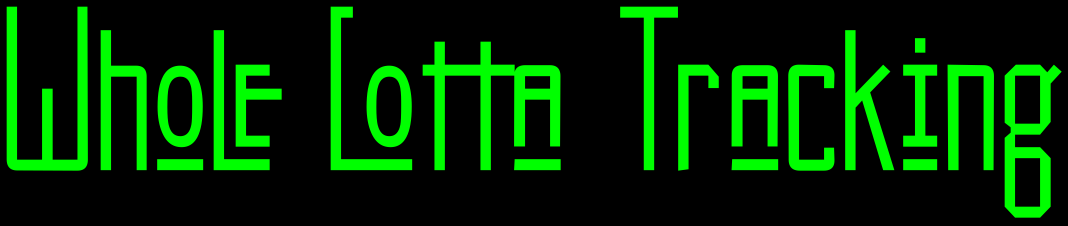

In this notebook, we will develop a Visual Object Tracking system for recognizing and tracking a target within a video.

Specifically, the following components will be used:
- [YOLOv11](https://docs.ultralytics.com/it/models/yolo11/) nano for detecting objects of interest in the input video
- [Openai CLIP](https://openai.com/index/clip/) for recognizing the target through image-image and text-image similarity
- [ByteTrack](https://github.com/ifzhang/ByteTrack) for tracking the target throughout the input video

**INSTRUCTIONS FOR USE**

1. Set up a GPU-enabled [Runtime](https://www.youtube.com/watch?v=6H381fUOolU)
2. Upload the resources (video and target image) directly to the server provided by Google Colaboratory or connect your own Google Drive (recommended)
3. Add a description of your target to the variable *target_description*

## Environment Configuration

**Installation of Required Packages**

In [1]:
!pip install opencv-python ultralytics lap==0.5.12 transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
   

In [2]:
!git clone https://github.com/openai/CLIP.git && cd CLIP
!pip install -r /content/CLIP/requirements.txt

Cloning into 'CLIP'...
remote: Enumerating objects: 256, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 256 (delta 126), reused 110 (delta 110), pack-reused 102 (from 1)
Receiving objects: 100% (256/256), 8.86 MiB | 34.25 MiB/s, done.
Resolving deltas: 100% (140/140), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.8 MB/s eta 0:00:00


**Importing Core Libraries**

In [3]:
import cv2
import numpy as np
import shutil
import os
import glob
import random
import pandas as pd

import matplotlib.cm as cm
from ultralytics import YOLO
from collections import defaultdict

from transformers import CLIPProcessor, CLIPModel
import torch
import CLIP.clip as clip
from PIL import Image

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Loading Pretrained Models

In [4]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Load YOLO11 model
model = YOLO("yolo11n.pt")
print(model.model.names)

100%|██████████| 5.35M/5.35M [00:00<00:00, 97.9MB/s]

{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microw

In [6]:
# Load CLIP
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 136MiB/s]


## Video Input Preparation

Now, let's mount your own Google Drive and link the video input

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
video_input_path = "/content/drive/MyDrive/WholeLottaTracking/joker_chase_long.mp4"  # Change video path
video_output_path_multitrack = "video_output_multitrack.mp4"

## Target Object Identification and Tracking

**Pipeline Configuration**

In [16]:
def generate_bgr_colors(objects):
  """Generates unique BGR colors for a list of objects.

  Args:
    objects: A list of objects.

  Returns:
    A dictionary mapping each object to a unique BGR color.
  """
  bgr_colors = {}
  for object in objects:
    # Generate a random BGR color
    b = random.randint(0, 255)
    g = random.randint(0, 255)
    r = random.randint(0, 255)
    bgr_colors[object] = (b, g, r)
  return bgr_colors

In [19]:
# a short description about target object
target_description = "a person with long hair, dressed as a clown, with a white painted face and wearing a red suit with a yellow waistcoat"
# path of an example image of target object
target_image_path = "/content/drive/MyDrive/WholeLottaTracking/target.jpg"
# yolo class about target
target_category = "person"

# object types to detect
objects_to_monitor = ["person","car"]
# monitored object colors
color_map = generate_bgr_colors(objects_to_monitor)
# if True, detected objects will be displayed in the output video
multi_obj = True

**Supporting Functions for Processing**

In [11]:
def create_dir(dir_path):
  """
  Create a new directory if it does not exist.

  Args:
      dir_path (str): The path of the directory to create.
  """
  if os.path.exists(dir_path):
      shutil.rmtree(dir_path)
      print(f"Deleted '{dir_path}'")

  os.makedirs(dir_path)
  print(f"Created new directory: '{dir_path}'")

In [12]:
def find_target(track_id_image_paths, target_description, target_image_path, model, preprocess, device, debug=True):
  """Identifies the target object among tracked objects using CLIP similarity.

  This function compares tracked objects with a target description and image
  using CLIP (Contrastive Language–Image Pre-training) to determine the
  most likely target object.

  Args:
      track_id_image_paths (dict): A dictionary mapping track IDs to image paths
                                   of the tracked objects.
      target_description (str): A textual description of the target object.
      target_image_path (str): The path to an image of the target object.
      model (CLIPModel): The CLIP model used for embedding generation.
      preprocess (CLIPProcessor): The CLIP processor used for image preprocessing.
      device (str): The device to run the computations on (e.g., "cuda" or "cpu").
      debug (bool, optional): Whether to print debugging information.
                              Defaults to True.

  Returns:
      int or None: The track ID of the identified target object, or None if no
                   suitable match is found.
  """
  image_path_list = list(track_id_image_paths.values())
  predicted_target = None

  images = []
  for image_path in image_path_list:
    images.append(preprocess(Image.open(image_path)).unsqueeze(0).to(device))

  target_image = preprocess(Image.open(target_image_path)).unsqueeze(0).to(device)

  images = torch.cat(images, dim=0)
  text = clip.tokenize([target_description]).to(device)

  with torch.no_grad():
    # image_features: shape (N, D) – una riga per immagine
    # text_features : shape (1, D) – descrizione testuale
    target_embedding = model.encode_image(target_image)
    image_embeddings = model.encode_image(images)
    text_embedding = model.encode_text(text)

  # normalization
  target_embedding = target_embedding / target_embedding.norm(dim=-1, keepdim=True)
  image_embeddings = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)
  text_embedding  = text_embedding  / text_embedding.norm(dim=-1, keepdim=True)

  # Calculate cosine similarity
  text_image_cos_sim = (image_embeddings @ text_embedding.T).squeeze()
  text_image_sim_01 = torch.clamp(text_image_cos_sim, min=0.0)   # valori ∈ [0, 1]

  target_image_cos_sim = (target_embedding @ image_embeddings.T).squeeze()
  target_image_sim_01 = torch.clamp(target_image_cos_sim, min=0.0) # valori ∈ [0, 1]

  cos_sim_01 = 0.3*text_image_sim_01.detach().cpu() + 0.7*target_image_sim_01.detach().cpu()

  df_score = pd.DataFrame({"track_id":track_id_image_paths.keys(), "image_path":image_path_list, "text_image_cos_sim":text_image_sim_01.detach().cpu().tolist(), "target_image_cos_sim":target_image_sim_01.detach().cpu().tolist(), "cos_sim": cos_sim_01})
  df_score = df_score.sort_values(by="cos_sim", ascending=False)

  if debug:
    print(df_score)

  # Find best match
  best_match = df_score.iloc[0]
  if best_match["cos_sim"]>0.5 and best_match["target_image_cos_sim"]>=0.65:
    print("Best matching track_id is {}".format(best_match["track_id"]))
    print("Best matching image path is {}".format(best_match["image_path"]))
    print("Best matching cosine similarity is {}".format(best_match["cos_sim"]))
    return best_match["track_id"]
  else:
    return None


In [13]:
def save_object_from_frame(frame, bboxes_data, target_category, frame_cnt):
    """Saves images of detected objects from a frame.

    This function extracts the regions of interest (ROIs) containing the detected
    objects specified in `objects_to_monitor` and saves them as individual images
    in a directory structure organized by frame number.

    Args:
        frame (numpy.ndarray): The input frame as a NumPy array.
        bboxes_data (list): A list of tuples, where each tuple contains the bounding
                              box coordinates, track ID, and object class for a
                              detected object.
        target_category (str): The category of the target object.
        frame_cnt (int): The current frame number.

    Returns:
        dict: A dictionary mapping track IDs to the paths of the saved object images.
    """
    tracked_objs = {}
    for box, track_id, obj_class in bboxes_data:
        if obj_class.upper() == target_category.upper():
            # for each frame we create new dir
            dir_path = os.path.join("frames", str(frame_cnt))
            if not os.path.exists(dir_path):
              create_dir(dir_path)

            # The YOLO model returns the (x, y) coordinates of the center
            # of the bounding box, along with its height and width.
            x_center, y_center, w_box, h_box = box

            # Compute the coordinates of the top-left and bottom-right corners
            # of the bounding box.
            x1 = int(x_center - w_box / 2)
            y1 = int(y_center - h_box / 2)
            x2 = int(x_center + w_box / 2)
            y2 = int(y_center + h_box / 2)

            # Extract the region of interest (ROI) containing the object of interest.
            obj_image = frame[y1:y2, x1:x2]

            # Save the image of tacked object
            output_path = os.path.join(dir_path, f"{obj_class}_{track_id}.jpg")
            cv2.imwrite(output_path, obj_image)
            tracked_objs[track_id] = output_path
    return tracked_objs

**Frame-by-Frame Analysis Execution**

In [21]:
create_dir("frames")

# extract video input information
cap = cv2.VideoCapture(video_input_path)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out_multitrack = cv2.VideoWriter(video_output_path_multitrack, fourcc, fps, (width, height))

# Store the track history
target_id = None
track_history = defaultdict(lambda: [])
frame_cnt = 0

while cap.isOpened():
    # Read a frame from the video
    success, frame = cap.read()
    print("--"*25 + "Frame {}".format(frame_cnt))
    if success:

        # Run YOLO11 tracking on the frame, persisting tracks between frames
        result = model.track(frame, tracker="bytetrack.yaml", persist=True)[0]

        # Get the boxes and track IDs
        if result.boxes and result.boxes.id is not None:
            boxes = result.boxes.xywh.cpu()
            track_ids = result.boxes.id.int().cpu().tolist()
            num_classes = result.boxes.cls.cpu().tolist()
            categorical_classes = [result.names[int(obj_class)] for obj_class in num_classes]

            # Check if target_id is set. If it is None, use the CLIP model to recognize the target and assign its ID
            if target_id == None or target_id not in track_ids:
              tracked_objs = save_object_from_frame(frame, zip(boxes, track_ids, categorical_classes), target_category, frame_cnt)
              if tracked_objs:
                target_id = find_target(tracked_objs, target_description, target_image_path, clip_model, clip_preprocess, device)

            # Plot the tracks
            for box, track_id, obj_class in zip(boxes, track_ids, categorical_classes):
                #if target_id:
                    if obj_class in objects_to_monitor:

                        # The YOLO model returns the (x, y) coordinates of the center
                        # of the bounding box, along with its height and width.
                        x_center, y_center, w_box, h_box = box

                        # Compute the coordinates of the top-left and bottom-right corners
                        # of the bounding box.
                        x1 = int(x_center - w_box / 2)
                        y1 = int(y_center - h_box / 2)
                        x2 = int(x_center + w_box / 2)
                        y2 = int(y_center + h_box / 2)

                        if track_id == target_id: #Target Object

                          track = track_history[track_id]
                          track.append((float(x_center), float(y_center)))

                          if len(track) > 2*fps:
                              track.pop(0)

                          # Draw the target bbox
                          cv2.rectangle(frame, (x1, y1), (x2, y2), (251, 9, 251), 2)

                          # Target Condition
                          label_text = "TARGET: {}".format(target_id)
                          label_pos = (x1, max(y1 - 5, 0))
                          cv2.putText(frame,
                              label_text,
                              label_pos,
                              cv2.FONT_HERSHEY_SIMPLEX,
                              0.8,        # font size
                              (251, 9, 251),# color font (B, G, R)
                              2,          # font thickness
                              cv2.LINE_AA)

                          #points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
                          #cv2.polylines(frame, [points], isClosed=False, color=(230, 230, 230), thickness=10)

                        elif track_id!=target_id and multi_obj: #No Target Objects

                          # Draw the tracking lines
                          cv2.rectangle(frame, (x1, y1), (x2, y2), color_map[obj_class], 2)

                          label_text = "{}".format(obj_class.upper())
                          label_pos = (x1, max(y1 - 5, 0))
                          cv2.putText(frame,
                                      label_text,
                                      label_pos,
                                      cv2.FONT_HERSHEY_SIMPLEX,
                                      0.8, # font size
                                      color_map[obj_class], # color font (B, G, R)
                                      2,   # font thickness
                                      cv2.LINE_AA)


            # Write frame into output video
            font_size = 1.2
            color_font = (249, 94, 5)
            font_thickness = 2
            font_type = cv2.FONT_HERSHEY_SIMPLEX
            font_y = 0
            decrease_height_value = 30
            font_y+=decrease_height_value

            cv2.putText(frame, "FRAME {}".format(frame_cnt), (0, font_y),
                        font_type, font_size, color_font, font_thickness,
                        cv2.LINE_AA)

            font_y+=decrease_height_value

            if target_id:
                cv2.putText(frame, "TARGET MATCHED", (0, font_y),
                          font_type, font_size, (5, 27, 249), font_thickness,
                          cv2.LINE_AA)
            else:
                cv2.putText(frame, "TARGET NOT MATCHED".format(frame_cnt), (0, font_y),
                font_type, font_size, color_font, font_thickness,
                cv2.LINE_AA)

            for i, obj_tm_class in enumerate(objects_to_monitor):
                cv2.putText(frame, "{} {}".format(obj_tm_class.upper(),
                        categorical_classes.count(obj_tm_class)), (0, font_y+(i+1)*decrease_height_value),
                        font_type, font_size, color_map[obj_tm_class], font_thickness,
                        cv2.LINE_AA)


            out_multitrack.write(frame)


    else:
        # Break the loop if the end of the video is reached
        break
    frame_cnt += 1

cap.release()
out_multitrack.release()

print("Target Tracking completed. Processed video has been saved!")

Deleted 'frames'
Created new directory: 'frames'
--------------------------------------------------Frame 0

0: 384x640 3 persons, 14.4ms
Speed: 2.5ms preprocess, 14.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/0'
   track_id                image_path  text_image_cos_sim  \
0      6727  frames/0/person_6727.jpg            0.317871   
1      6700  frames/0/person_6700.jpg            0.176880   
2      6712  frames/0/person_6712.jpg            0.165771   

   target_image_cos_sim   cos_sim  
0              0.684082  0.574219  
1              0.646484  0.505859  
2              0.605469  0.473633  
Best matching track_id is 6727
Best matching image path is frames/0/person_6727.jpg
Best matching cosine similarity is 0.57421875
--------------------------------------------------Frame 1

0: 384x640 10 persons, 1 truck, 1 backpack, 10.5ms
Speed: 2.4ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
------

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


--------------------------------------------------Frame 6

0: 384x640 10 persons, 1 car, 1 truck, 1 handbag, 11.5ms
Speed: 2.2ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 7

0: 384x640 9 persons, 1 car, 1 truck, 1 handbag, 11.2ms
Speed: 3.0ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 8

0: 384x640 9 persons, 1 car, 1 truck, 1 handbag, 12.5ms
Speed: 2.6ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 9

0: 384x640 8 persons, 1 car, 1 truck, 1 handbag, 12.1ms
Speed: 2.7ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 10

0: 384x640 9 persons, 1 car, 1 truck, 1 handbag, 16.2ms
Speed: 2.5ms preprocess, 16.2ms inf

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/23'
   track_id                 image_path  text_image_cos_sim  \
2      6734  frames/23/person_6734.jpg            0.181030   
0      6732  frames/23/person_6732.jpg            0.182983   
3      6795  frames/23/person_6795.jpg            0.211914   
1      6733  frames/23/person_6733.jpg            0.158936   

   target_image_cos_sim   cos_sim  
2              0.619629  0.488281  
0              0.612793  0.483887  
3              0.588867  0.475586  
1              0.585449  0.457520  
--------------------------------------------------Frame 24

0: 384x640 4 persons, 4 cars, 1 backpack, 10.2ms
Speed: 2.3ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/24'
   track_id                 image_path  text_image_cos_sim  \
0      6732  frames/24/person_6732.jpg            0.189453   
1      6733  frames/24/person_6733.jpg            0.183594   
2      6734  frames/24/person_6734.jpg         

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/25'
   track_id                 image_path  text_image_cos_sim  \
2      6734  frames/25/person_6734.jpg            0.173706   
0      6732  frames/25/person_6732.jpg            0.188721   
3      6795  frames/25/person_6795.jpg            0.224487   
1      6733  frames/25/person_6733.jpg            0.160278   

   target_image_cos_sim   cos_sim  
2              0.619141  0.485352  
0              0.610840  0.484131  
3              0.581055  0.474121  
1              0.582031  0.455566  
--------------------------------------------------Frame 26

0: 384x640 2 persons, 3 cars, 13.7ms
Speed: 2.0ms preprocess, 13.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/26'
   track_id                 image_path  text_image_cos_sim  \
1      6795  frames/26/person_6795.jpg            0.207397   
0      6732  frames/26/person_6732.jpg            0.169922   

   target_image_cos_sim   cos_sim  
1              0.60058

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/27'
   track_id                 image_path  text_image_cos_sim  \
0      6732  frames/27/person_6732.jpg            0.184204   
1      6795  frames/27/person_6795.jpg            0.191650   
2      6811  frames/27/person_6811.jpg            0.193481   

   target_image_cos_sim   cos_sim  
0              0.612793  0.484131  
1              0.608398  0.483398  
2              0.584473  0.467285  
--------------------------------------------------Frame 28

0: 384x640 3 persons, 3 cars, 9.7ms
Speed: 2.0ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/28'
   track_id                 image_path  text_image_cos_sim  \
0      6732  frames/28/person_6732.jpg            0.198486   
1      6795  frames/28/person_6795.jpg            0.200195   
2      6811  frames/28/person_6811.jpg            0.175903   

   target_image_cos_sim   cos_sim  
0              0.607422  0.484863  
1              0.602539 

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/29'
   track_id                 image_path  text_image_cos_sim  \
1      6795  frames/29/person_6795.jpg            0.201782   
0      6732  frames/29/person_6732.jpg            0.179932   
2      6811  frames/29/person_6811.jpg            0.187866   

   target_image_cos_sim   cos_sim  
1              0.606934  0.485352  
0              0.606934  0.478760  
2              0.584473  0.465576  
--------------------------------------------------Frame 30

0: 384x640 3 persons, 3 cars, 12.8ms
Speed: 2.2ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/30'
   track_id                 image_path  text_image_cos_sim  \
2      6811  frames/30/person_6811.jpg            0.191650   
0      6732  frames/30/person_6732.jpg            0.184326   
1      6795  frames/30/person_6795.jpg            0.181763   

   target_image_cos_sim   cos_sim  
2              0.601562  0.478516  
0              0.59863

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/31'
   track_id                 image_path  text_image_cos_sim  \
0      6732  frames/31/person_6732.jpg            0.174683   

   target_image_cos_sim                              cos_sim  
0               0.60791  tensor(0.4780, dtype=torch.float16)  
--------------------------------------------------Frame 32

0: 384x640 1 person, 4 cars, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/32'
   track_id                 image_path  text_image_cos_sim  \
0      6732  frames/32/person_6732.jpg            0.185181   

   target_image_cos_sim                              cos_sim  
0              0.627441  tensor(0.4946, dtype=torch.float16)  
--------------------------------------------------Frame 33

0: 384x640 4 cars, 9.8ms
Speed: 2.4ms preprocess, 9.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Fram

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/53'
   track_id                 image_path  text_image_cos_sim  \
0      6831  frames/53/person_6831.jpg            0.191040   
1      6833  frames/53/person_6833.jpg            0.177002   

   target_image_cos_sim   cos_sim  
0              0.631836  0.499756  
1              0.599609  0.472656  
--------------------------------------------------Frame 54

0: 384x640 2 persons, 5 cars, 1 truck, 11.8ms
Speed: 2.2ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/54'
   track_id                 image_path  text_image_cos_sim  \
0      6831  frames/54/person_6831.jpg            0.191040   
1      6833  frames/54/person_6833.jpg            0.176392   

   target_image_cos_sim   cos_sim  
0              0.631836  0.499756  
1              0.599121  0.472412  
--------------------------------------------------Frame 55

0: 384x640 1 person, 4 cars, 1 truck, 1 chair, 9.1ms
Speed: 2.1ms preprocess,

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/55'
   track_id                 image_path  text_image_cos_sim  \
0      6831  frames/55/person_6831.jpg             0.17334   

   target_image_cos_sim                              cos_sim  
0              0.637695  tensor(0.4983, dtype=torch.float16)  
--------------------------------------------------Frame 56

0: 384x640 2 persons, 4 cars, 1 truck, 1 chair, 20.5ms
Speed: 4.8ms preprocess, 20.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/56'
   track_id                 image_path  text_image_cos_sim  \
1      6835  frames/56/person_6835.jpg            0.205688   
0      6831  frames/56/person_6831.jpg            0.174683   

   target_image_cos_sim   cos_sim  
1              0.620605  0.496094  
0              0.633301  0.495850  
--------------------------------------------------Frame 57

0: 384x640 2 persons, 3 cars, 1 truck, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 1.4ms postprocess per ima

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/58'
   track_id                 image_path  text_image_cos_sim  \
0      6831  frames/58/person_6831.jpg            0.184204   
1      6835  frames/58/person_6835.jpg            0.200439   
2      6836  frames/58/person_6836.jpg            0.179443   

   target_image_cos_sim   cos_sim  
0              0.632324  0.497803  
1              0.614258  0.489990  
2              0.614746  0.484375  
--------------------------------------------------Frame 59

0: 384x640 3 persons, 3 cars, 1 motorcycle, 1 truck, 12.6ms
Speed: 3.1ms preprocess, 12.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/59'
   track_id                 image_path  text_image_cos_sim  \
0      6831  frames/59/person_6831.jpg            0.172974   
2      6836  frames/59/person_6836.jpg            0.179688   
1      6835  frames/59/person_6835.jpg            0.194946   

   target_image_cos_sim   cos_sim  
0              0.625488  0.489746  

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/60'
   track_id                 image_path  text_image_cos_sim  \
0      6831  frames/60/person_6831.jpg            0.180664   
1      6835  frames/60/person_6835.jpg            0.199463   
2      6836  frames/60/person_6836.jpg            0.183350   

   target_image_cos_sim   cos_sim  
0              0.635254  0.498779  
1              0.614746  0.490234  
2              0.613281  0.484131  
--------------------------------------------------Frame 61

0: 384x640 3 persons, 3 cars, 1 motorcycle, 1 truck, 11.5ms
Speed: 2.2ms preprocess, 11.5ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/61'
   track_id                 image_path  text_image_cos_sim  \
0      6831  frames/61/person_6831.jpg            0.179932   
1      6835  frames/61/person_6835.jpg            0.198730   
2      6836  frames/61/person_6836.jpg            0.179565   

   target_image_cos_sim   cos_sim  
0              0.630371  0.495117  

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/62'
   track_id                 image_path  text_image_cos_sim  \
3      6795  frames/62/person_6795.jpg            0.274170   
0      6831  frames/62/person_6831.jpg            0.177368   
2      6836  frames/62/person_6836.jpg            0.192261   
1      6835  frames/62/person_6835.jpg            0.187744   

   target_image_cos_sim   cos_sim  
3              0.654785  0.540527  
0              0.641113  0.501953  
2              0.592285  0.472168  
1              0.572266  0.457031  
Best matching track_id is 6795
Best matching image path is frames/62/person_6795.jpg
Best matching cosine similarity is 0.54052734375
--------------------------------------------------Frame 63

0: 384x640 5 persons, 2 cars, 1 bus, 1 train, 9.1ms
Speed: 2.3ms preprocess, 9.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 64

0: 384x640 5 persons, 2 cars, 1 train, 1 truck, 9.1ms
Speed: 2.2ms prepr

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


--------------------------------------------------Frame 69

0: 384x640 7 persons, 1 car, 1 bus, 1 backpack, 20.6ms
Speed: 2.8ms preprocess, 20.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 70

0: 384x640 9 persons, 1 car, 1 bus, 1 backpack, 1 umbrella, 11.2ms
Speed: 2.2ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 71

0: 384x640 8 persons, 1 car, 1 backpack, 8.7ms
Speed: 2.7ms preprocess, 8.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 72

0: 384x640 9 persons, 1 car, 1 backpack, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 73

0: 384x640 9 persons, 1 car, 1 backpack, 13.5ms
Speed: 2.2ms preprocess, 13.5ms inference, 1.5ms p

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


--------------------------------------------------Frame 99

0: 384x640 9 persons, 4 cars, 2 trucks, 1 traffic light, 10.4ms
Speed: 2.0ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 100

0: 384x640 10 persons, 4 cars, 2 trucks, 1 traffic light, 10.7ms
Speed: 2.4ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 101

0: 384x640 10 persons, 4 cars, 2 trucks, 1 traffic light, 9.3ms
Speed: 2.2ms preprocess, 9.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 102

0: 384x640 10 persons, 4 cars, 2 trucks, 1 traffic light, 13.9ms
Speed: 3.1ms preprocess, 13.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 103

0: 384x640 9 persons, 4 cars, 2 trucks, 9.0ms
Speed

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


--------------------------------------------------Frame 121

0: 384x640 9 persons, 3 cars, 1 truck, 1 handbag, 13.1ms
Speed: 2.1ms preprocess, 13.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 122

0: 384x640 9 persons, 3 cars, 1 truck, 1 handbag, 14.7ms
Speed: 2.1ms preprocess, 14.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 123

0: 384x640 9 persons, 3 cars, 1 truck, 1 handbag, 12.1ms
Speed: 4.0ms preprocess, 12.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 124

0: 384x640 9 persons, 3 cars, 1 truck, 1 handbag, 11.6ms
Speed: 2.1ms preprocess, 11.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 125

0: 384x640 9 persons, 3 cars, 1 truck, 1 handbag, 13.5ms
Speed: 2.2ms preproces

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


--------------------------------------------------Frame 134

0: 384x640 7 persons, 4 cars, 1 truck, 12.7ms
Speed: 2.1ms preprocess, 12.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 135

0: 384x640 7 persons, 5 cars, 1 truck, 11.2ms
Speed: 2.3ms preprocess, 11.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 136

0: 384x640 7 persons, 5 cars, 1 truck, 15.5ms
Speed: 6.6ms preprocess, 15.5ms inference, 3.4ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 137

0: 384x640 7 persons, 5 cars, 1 truck, 15.8ms
Speed: 2.4ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 138

0: 384x640 7 persons, 5 cars, 1 truck, 13.6ms
Speed: 2.3ms preprocess, 13.6ms inference, 2.0ms postprocess per image at sha

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/491'
   track_id                  image_path  text_image_cos_sim  \
4      6868  frames/491/person_6868.jpg            0.317871   
3      7301  frames/491/person_7301.jpg            0.218262   
1      7276  frames/491/person_7276.jpg            0.205933   
2      7328  frames/491/person_7328.jpg            0.209717   
0      7034  frames/491/person_7034.jpg            0.209351   
5      7048  frames/491/person_7048.jpg            0.204590   
6      7367  frames/491/person_7367.jpg            0.202637   

   target_image_cos_sim   cos_sim  
4              0.758789  0.626465  
3              0.641602  0.514648  
1              0.636230  0.506836  
2              0.631348  0.504883  
0              0.618164  0.495361  
5              0.610352  0.488525  
6              0.592773  0.475830  
Best matching track_id is 6868
Best matching image path is frames/491/person_6868.jpg
Best matching cosine similarity is 0.62646484375
------------------------------------

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


--------------------------------------------------Frame 496

0: 384x640 9 persons, 13.4ms
Speed: 2.3ms preprocess, 13.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 497

0: 384x640 10 persons, 15.5ms
Speed: 2.2ms preprocess, 15.5ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 498

0: 384x640 10 persons, 16.8ms
Speed: 2.3ms preprocess, 16.8ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 499

0: 384x640 9 persons, 13.5ms
Speed: 2.3ms preprocess, 13.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 500

0: 384x640 9 persons, 14.7ms
Speed: 2.2ms preprocess, 14.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 501

0:

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/667'
   track_id                  image_path  text_image_cos_sim  \
0      7545  frames/667/person_7545.jpg            0.193115   
1      7548  frames/667/person_7548.jpg            0.186768   
2      7552  frames/667/person_7552.jpg            0.202026   

   target_image_cos_sim   cos_sim  
0              0.619629  0.491699  
1              0.592285  0.470703  
2              0.582031  0.468018  
--------------------------------------------------Frame 668

0: 384x640 3 persons, 2 cars, 2 traffic lights, 12.3ms
Speed: 2.2ms preprocess, 12.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/668'
   track_id                  image_path  text_image_cos_sim  \
0      7545  frames/668/person_7545.jpg            0.192505   
1      7548  frames/668/person_7548.jpg            0.186401   
2      7552  frames/668/person_7552.jpg            0.202026   

   target_image_cos_sim   cos_sim  
0              0.623535  0.49

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/669'
   track_id                  image_path  text_image_cos_sim  \
1      7548  frames/669/person_7548.jpg            0.195923   
0      7545  frames/669/person_7545.jpg            0.189819   
2      7552  frames/669/person_7552.jpg            0.187134   

   target_image_cos_sim   cos_sim  
1              0.621094  0.493652  
0              0.616699  0.488525  
2              0.605957  0.480225  
--------------------------------------------------Frame 670

0: 384x640 3 persons, 3 cars, 1 truck, 2 traffic lights, 12.7ms
Speed: 2.2ms preprocess, 12.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/670'
   track_id                  image_path  text_image_cos_sim  \
1      7548  frames/670/person_7548.jpg            0.195190   
0      7545  frames/670/person_7545.jpg            0.187134   
2      7552  frames/670/person_7552.jpg            0.193848   

   target_image_cos_sim   cos_sim  
1              0.625

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/671'
   track_id                  image_path  text_image_cos_sim  \
0      7545  frames/671/person_7545.jpg            0.214966   
1      7548  frames/671/person_7548.jpg            0.203491   
2      7552  frames/671/person_7552.jpg            0.174805   

   target_image_cos_sim   cos_sim  
0              0.610840  0.491943  
1              0.615234  0.491699  
2              0.590332  0.465820  
--------------------------------------------------Frame 672

0: 384x640 4 persons, 1 car, 1 truck, 1 traffic light, 10.2ms
Speed: 2.0ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/672'
   track_id                  image_path  text_image_cos_sim  \
1      7548  frames/672/person_7548.jpg            0.203491   
3      7564  frames/672/person_7564.jpg            0.247681   
0      7545  frames/672/person_7545.jpg            0.198364   
2      7552  frames/672/person_7552.jpg            0.182739

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/673'
   track_id                  image_path  text_image_cos_sim  \
3      7564  frames/673/person_7564.jpg            0.248535   
1      7548  frames/673/person_7548.jpg            0.209106   
0      7545  frames/673/person_7545.jpg            0.196289   
2      7552  frames/673/person_7552.jpg            0.185913   

   target_image_cos_sim   cos_sim  
3              0.616699  0.506348  
1              0.611816  0.490967  
0              0.611328  0.486816  
2              0.588379  0.467773  
--------------------------------------------------Frame 674

0: 384x640 4 persons, 1 car, 1 truck, 1 traffic light, 10.9ms
Speed: 2.8ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/674'
   track_id                  image_path  text_image_cos_sim  \
3      7564  frames/674/person_7564.jpg            0.234741   
1      7548  frames/674/person_7548.jpg            0.210815   
0      7545  frames/674

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/675'
   track_id                  image_path  text_image_cos_sim  \
3      7564  frames/675/person_7564.jpg            0.232178   
1      7548  frames/675/person_7548.jpg            0.216553   
0      7545  frames/675/person_7545.jpg            0.190552   
2      7552  frames/675/person_7552.jpg            0.181396   

   target_image_cos_sim   cos_sim  
3              0.606934  0.494385  
1              0.613281  0.494141  
0              0.608887  0.483398  
2              0.586914  0.465332  
--------------------------------------------------Frame 676

0: 384x640 4 persons, 1 car, 1 truck, 2 traffic lights, 14.3ms
Speed: 2.3ms preprocess, 14.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/676'
   track_id                  image_path  text_image_cos_sim  \
1      7548  frames/676/person_7548.jpg            0.217407   
0      7545  frames/676/person_7545.jpg            0.204468   
3      7564  frames/67

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/677'
   track_id                  image_path  text_image_cos_sim  \
3      7564  frames/677/person_7564.jpg            0.248535   
1      7548  frames/677/person_7548.jpg            0.214844   
0      7545  frames/677/person_7545.jpg            0.201416   
2      7552  frames/677/person_7552.jpg            0.186157   
4      7576  frames/677/person_7576.jpg            0.127075   

   target_image_cos_sim   cos_sim  
3              0.594727  0.490723  
1              0.605469  0.488281  
0              0.609863  0.487305  
2              0.594727  0.472168  
4              0.550781  0.423584  
--------------------------------------------------Frame 678

0: 384x640 5 persons, 1 car, 1 truck, 3 traffic lights, 12.3ms
Speed: 4.2ms preprocess, 12.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/678'
   track_id                  image_path  text_image_cos_sim  \
3      7564  frames/678/person_7564.jpg          

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/679'
   track_id                  image_path  text_image_cos_sim  \
1      7548  frames/679/person_7548.jpg            0.222534   
0      7545  frames/679/person_7545.jpg            0.213379   
2      7552  frames/679/person_7552.jpg            0.197754   
3      7564  frames/679/person_7564.jpg            0.228394   
4      7576  frames/679/person_7576.jpg            0.130493   

   target_image_cos_sim   cos_sim  
1              0.615723  0.497559  
0              0.618652  0.497070  
2              0.603027  0.481445  
3              0.582520  0.476318  
4              0.544922  0.420410  
--------------------------------------------------Frame 680

0: 384x640 5 persons, 2 cars, 1 truck, 3 traffic lights, 14.1ms
Speed: 2.1ms preprocess, 14.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/680'
   track_id                  image_path  text_image_cos_sim  \
0      7545  frames/680/person_7545.jpg         

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/681'
   track_id                  image_path  text_image_cos_sim  \
0      7545  frames/681/person_7545.jpg            0.215942   
3      7564  frames/681/person_7564.jpg            0.224976   
1      7548  frames/681/person_7548.jpg            0.206787   
2      7552  frames/681/person_7552.jpg            0.191772   
4      7576  frames/681/person_7576.jpg            0.134521   

   target_image_cos_sim   cos_sim  
0              0.633789  0.508301  
3              0.600586  0.487793  
1              0.604004  0.484863  
2              0.573730  0.459229  
4              0.550781  0.425781  
--------------------------------------------------Frame 682

0: 384x640 5 persons, 2 cars, 1 truck, 3 traffic lights, 13.1ms
Speed: 2.3ms preprocess, 13.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/682'
   track_id                  image_path  text_image_cos_sim  \
0      7545  frames/682/person_7545.jpg         

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/683'
   track_id                  image_path  text_image_cos_sim  \
2      7564  frames/683/person_7564.jpg            0.221069   
1      7548  frames/683/person_7548.jpg            0.221191   
0      7545  frames/683/person_7545.jpg            0.185303   
3      7576  frames/683/person_7576.jpg            0.132202   

   target_image_cos_sim   cos_sim  
2              0.624023  0.502930  
1              0.620117  0.500488  
0              0.606445  0.480225  
3              0.551270  0.425781  
--------------------------------------------------Frame 684

0: 384x640 5 persons, 2 cars, 1 truck, 2 traffic lights, 10.7ms
Speed: 2.1ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/684'
   track_id                  image_path  text_image_cos_sim  \
2      7564  frames/684/person_7564.jpg            0.220459   
1      7548  frames/684/person_7548.jpg            0.209961   
0      7545  frames/6

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/685'
   track_id                  image_path  text_image_cos_sim  \
2      7564  frames/685/person_7564.jpg            0.225220   
1      7548  frames/685/person_7548.jpg            0.197510   
0      7545  frames/685/person_7545.jpg            0.195312   
3      7576  frames/685/person_7576.jpg            0.140869   
4      7586  frames/685/person_7586.jpg            0.133057   

   target_image_cos_sim   cos_sim  
2              0.631348  0.509277  
1              0.598145  0.478027  
0              0.596680  0.476318  
3              0.559082  0.433594  
4              0.557617  0.430176  
--------------------------------------------------Frame 686

0: 384x640 5 persons, 2 cars, 1 truck, 2 traffic lights, 12.2ms
Speed: 2.2ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/686'
   track_id                  image_path  text_image_cos_sim  \
2      7564  frames/686/person_7564.jpg         

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/687'
   track_id                  image_path  text_image_cos_sim  \
2      7564  frames/687/person_7564.jpg            0.220093   
0      7545  frames/687/person_7545.jpg            0.193359   
1      7548  frames/687/person_7548.jpg            0.212036   
3      7576  frames/687/person_7576.jpg            0.141357   
4      7586  frames/687/person_7586.jpg            0.129028   

   target_image_cos_sim   cos_sim  
2              0.618652  0.499023  
0              0.622070  0.493652  
1              0.587891  0.475098  
3              0.559570  0.434082  
4              0.550781  0.424316  
--------------------------------------------------Frame 688

0: 384x640 5 persons, 2 cars, 1 truck, 2 traffic lights, 9.4ms
Speed: 2.2ms preprocess, 9.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/688'
   track_id                  image_path  text_image_cos_sim  \
2      7564  frames/688/person_7564.jpg           

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/689'
   track_id                  image_path  text_image_cos_sim  \
2      7564  frames/689/person_7564.jpg            0.214844   
1      7548  frames/689/person_7548.jpg            0.215942   
0      7545  frames/689/person_7545.jpg            0.170410   
4      7586  frames/689/person_7586.jpg            0.138550   
3      7576  frames/689/person_7576.jpg            0.131958   

   target_image_cos_sim   cos_sim  
2              0.614258  0.494385  
1              0.599609  0.484375  
0              0.599609  0.470703  
4              0.560059  0.433594  
3              0.550293  0.424805  
--------------------------------------------------Frame 690

0: 384x640 5 persons, 2 cars, 1 truck, 2 traffic lights, 13.9ms
Speed: 2.3ms preprocess, 13.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/690'
   track_id                  image_path  text_image_cos_sim  \
2      7564  frames/690/person_7564.jpg         

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/691'
   track_id                  image_path  text_image_cos_sim  \
2      7564  frames/691/person_7564.jpg            0.226562   
0      7545  frames/691/person_7545.jpg            0.198242   
1      7548  frames/691/person_7548.jpg            0.200073   
4      7586  frames/691/person_7586.jpg            0.138428   
3      7576  frames/691/person_7576.jpg            0.146851   

   target_image_cos_sim   cos_sim  
2              0.613281  0.497070  
0              0.613770  0.489258  
1              0.598145  0.478760  
4              0.568848  0.439697  
3              0.552246  0.430664  
--------------------------------------------------Frame 692

0: 384x640 6 persons, 2 cars, 1 truck, 1 traffic light, 9.2ms
Speed: 3.1ms preprocess, 9.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/692'
   track_id                  image_path  text_image_cos_sim  \
2      7564  frames/692/person_7564.jpg            

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/693'
   track_id                  image_path  text_image_cos_sim  \
2      7564  frames/693/person_7564.jpg            0.224121   
0      7545  frames/693/person_7545.jpg            0.203125   
1      7548  frames/693/person_7548.jpg            0.218018   
3      7593  frames/693/person_7593.jpg            0.228149   

   target_image_cos_sim   cos_sim  
2              0.613770  0.497070  
0              0.614746  0.491455  
1              0.603027  0.487549  
3              0.596680  0.486084  
--------------------------------------------------Frame 694

0: 384x640 4 persons, 2 cars, 1 truck, 1 traffic light, 12.8ms
Speed: 2.3ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/694'
   track_id                  image_path  text_image_cos_sim  \
2      7564  frames/694/person_7564.jpg            0.223022   
0      7545  frames/694/person_7545.jpg            0.204834   
3      7593  frames/69

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/695'
   track_id                  image_path  text_image_cos_sim  \
0      7545  frames/695/person_7545.jpg            0.220581   
1      7548  frames/695/person_7548.jpg            0.216675   
2      7564  frames/695/person_7564.jpg            0.206055   

   target_image_cos_sim   cos_sim  
0              0.620605  0.500488  
1              0.620117  0.499023  
2              0.611816  0.489990  
--------------------------------------------------Frame 696

0: 384x640 3 persons, 2 cars, 1 truck, 1 traffic light, 9.6ms
Speed: 4.2ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/696'
   track_id                  image_path  text_image_cos_sim  \
2      7564  frames/696/person_7564.jpg            0.222168   
0      7545  frames/696/person_7545.jpg            0.224121   
1      7548  frames/696/person_7548.jpg            0.231445   

   target_image_cos_sim   cos_sim  
2              0.621094

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/697'
   track_id                  image_path  text_image_cos_sim  \
0      7545  frames/697/person_7545.jpg            0.227539   
2      7564  frames/697/person_7564.jpg            0.208618   
1      7548  frames/697/person_7548.jpg            0.235474   

   target_image_cos_sim   cos_sim  
0              0.618652  0.501465  
2              0.621094  0.497314  
1              0.599121  0.489990  
--------------------------------------------------Frame 698

0: 384x640 3 persons, 2 cars, 1 truck, 1 traffic light, 10.9ms
Speed: 2.2ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/698'
   track_id                  image_path  text_image_cos_sim  \
0      7545  frames/698/person_7545.jpg            0.223511   
2      7564  frames/698/person_7564.jpg            0.206055   
1      7548  frames/698/person_7548.jpg            0.234009   

   target_image_cos_sim   cos_sim  
0              0.6196

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/699'
   track_id                  image_path  text_image_cos_sim  \
0      7545  frames/699/person_7545.jpg            0.217773   
2      7564  frames/699/person_7564.jpg            0.203491   
1      7548  frames/699/person_7548.jpg            0.232178   

   target_image_cos_sim   cos_sim  
0              0.626465  0.503906  
2              0.618164  0.493652  
1              0.604980  0.493164  
--------------------------------------------------Frame 700

0: 384x640 3 persons, 2 cars, 1 truck, 1 traffic light, 11.6ms
Speed: 2.4ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/700'
   track_id                  image_path  text_image_cos_sim  \
2      7564  frames/700/person_7564.jpg            0.214722   
0      7545  frames/700/person_7545.jpg            0.205811   
1      7548  frames/700/person_7548.jpg            0.226685   

   target_image_cos_sim   cos_sim  
2              0.6367

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/701'
   track_id                  image_path  text_image_cos_sim  \
2      7564  frames/701/person_7564.jpg            0.222900   
0      7545  frames/701/person_7545.jpg            0.193359   
1      7548  frames/701/person_7548.jpg            0.230103   

   target_image_cos_sim   cos_sim  
2              0.629883  0.507812  
0              0.614746  0.488525  
1              0.596191  0.486328  
--------------------------------------------------Frame 702

0: 384x640 3 persons, 2 cars, 1 truck, 1 traffic light, 13.8ms
Speed: 3.0ms preprocess, 13.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/702'
   track_id                  image_path  text_image_cos_sim  \
1      7548  frames/702/person_7548.jpg            0.236206   
2      7564  frames/702/person_7564.jpg            0.220337   
0      7545  frames/702/person_7545.jpg            0.201416   

   target_image_cos_sim   cos_sim  
1              0.6142

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/703'
   track_id                  image_path  text_image_cos_sim  \
0      7545  frames/703/person_7545.jpg            0.221680   
2      7564  frames/703/person_7564.jpg            0.215332   
1      7548  frames/703/person_7548.jpg            0.226440   

   target_image_cos_sim   cos_sim  
0              0.629883  0.507324  
2              0.619629  0.498535  
1              0.598145  0.486572  
--------------------------------------------------Frame 704

0: 384x640 3 persons, 2 cars, 1 traffic light, 13.9ms
Speed: 2.2ms preprocess, 13.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/704'
   track_id                  image_path  text_image_cos_sim  \
0      7545  frames/704/person_7545.jpg            0.227051   
2      7564  frames/704/person_7564.jpg            0.214600   
1      7548  frames/704/person_7548.jpg            0.223755   

   target_image_cos_sim   cos_sim  
0              0.636230  0.513

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/705'
   track_id                  image_path  text_image_cos_sim  \
0      7545  frames/705/person_7545.jpg            0.219727   
2      7564  frames/705/person_7564.jpg            0.207886   
1      7548  frames/705/person_7548.jpg            0.206177   

   target_image_cos_sim   cos_sim  
0              0.622559  0.501953  
2              0.617188  0.494629  
1              0.593750  0.477295  
--------------------------------------------------Frame 706

0: 384x640 3 persons, 2 cars, 1 traffic light, 16.1ms
Speed: 2.3ms preprocess, 16.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/706'
   track_id                  image_path  text_image_cos_sim  \
0      7545  frames/706/person_7545.jpg            0.213135   
2      7564  frames/706/person_7564.jpg            0.210693   
1      7548  frames/706/person_7548.jpg            0.211914   

   target_image_cos_sim   cos_sim  
0              0.618652  0.497070  
2              0.611816  0.491455  
1              0.580078  0.469727  
--------------------------------------------------Frame 707

0: 384x640 5 persons, 2 cars, 1 traffic light, 16.2ms
Speed: 2.3ms preprocess, 16.2ms inference, 5.3ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/707'
   track_id                  image_path  text_image_cos_sim  \
0      7545  frames/707/person_7545.jpg            0.210693   
1      7548  frames/707/person_7548.jpg            0.207031   
2      7564  frames/707/person_7564.jpg            0.191162   
4      7586  frames/707/person_7586.jpg            0.147461   
3      7576  frames/707/person_7576.jpg            0.157593   

   target_image_cos_sim   cos_sim  
0              0.625977  0.501465  
1              0.598145  0.480713  
2              0.588379  0.469238  
4              0.559082  0.435547  
3              0.552734  0.434326  
--------------------------------------------------Frame 708

0: 384x640 5 persons, 3 cars, 2 traffic lights, 12.6ms
Speed: 2.7ms preprocess, 12.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/708'
   track_id                  image_path  text_image_cos_sim  \
0      7545  frames/708/person_7545.jpg            0.215332   
1      7548  frames/708/person_7548.jpg            0.231323   
2      7564  frames/708/person_7564.jpg            0.204102   
4      7586  frames/708/person_7586.jpg            0.153320   
3      7576  frames/708/person_7576.jpg            0.157227   

   target_image_cos_sim   cos_sim  
0              0.617676  0.497070  
1              0.603027  0.491455  
2              0.592773  0.476318  
4              0.556641  0.435547  
3              0.552246  0.433594  
--------------------------------------------------Frame 709

0: 384x640 5 persons, 3 cars, 2 traffic lights, 17.0ms
Speed: 2.3ms preprocess, 17.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/709'
   track_id                  image_path  text_image_cos_sim  \
0      7545  frames/709/person_7545.jpg            0.2178

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


   track_id                  image_path  text_image_cos_sim  \
0      7545  frames/710/person_7545.jpg            0.198120   
1      7548  frames/710/person_7548.jpg            0.212036   
2      7564  frames/710/person_7564.jpg            0.197876   
4      7586  frames/710/person_7586.jpg            0.148071   
3      7576  frames/710/person_7576.jpg            0.141602   

   target_image_cos_sim   cos_sim  
0              0.609863  0.486328  
1              0.594727  0.479980  
2              0.583984  0.468018  
4              0.552246  0.430908  
3              0.541016  0.421143  
--------------------------------------------------Frame 711

0: 384x640 5 persons, 3 cars, 2 traffic lights, 12.6ms
Speed: 2.1ms preprocess, 12.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/711'
   track_id                  image_path  text_image_cos_sim  \
0      7545  frames/711/person_7545.jpg            0.212769   
1      7548  frames/711/person

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


   track_id                  image_path  text_image_cos_sim  \
0      7545  frames/712/person_7545.jpg            0.219727   
2      7564  frames/712/person_7564.jpg            0.228027   
1      7548  frames/712/person_7548.jpg            0.207031   
3      7576  frames/712/person_7576.jpg            0.152588   
4      7586  frames/712/person_7586.jpg            0.148315   

   target_image_cos_sim   cos_sim  
0              0.622559  0.501953  
2              0.614746  0.498779  
1              0.592773  0.477051  
3              0.558594  0.437012  
4              0.558105  0.435059  
--------------------------------------------------Frame 713

0: 384x640 5 persons, 3 cars, 4 traffic lights, 20.9ms
Speed: 2.2ms preprocess, 20.9ms inference, 5.0ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/713'
   track_id                  image_path  text_image_cos_sim  \
0      7545  frames/713/person_7545.jpg            0.212402   
2      7564  frames/713/person

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/714'
   track_id                  image_path  text_image_cos_sim  \
2      7564  frames/714/person_7564.jpg            0.231445   
0      7545  frames/714/person_7545.jpg            0.213623   
1      7548  frames/714/person_7548.jpg            0.204224   
3      7576  frames/714/person_7576.jpg            0.152344   
4      7586  frames/714/person_7586.jpg            0.152100   

   target_image_cos_sim   cos_sim  
2              0.617676  0.501953  
0              0.624023  0.500977  
1              0.584473  0.470459  
3              0.566895  0.442383  
4              0.559082  0.437012  
--------------------------------------------------Frame 715

0: 384x640 5 persons, 3 cars, 4 traffic lights, 13.6ms
Speed: 2.1ms preprocess, 13.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/715'
   track_id                  image_path  text_image_cos_sim  \
2      7564  frames/715/person_7564.jpg            0.2304

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


0: 384x640 5 persons, 3 cars, 4 traffic lights, 15.4ms
Speed: 3.0ms preprocess, 15.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/716'
   track_id                  image_path  text_image_cos_sim  \
2      7564  frames/716/person_7564.jpg            0.238770   
0      7545  frames/716/person_7545.jpg            0.194458   
1      7548  frames/716/person_7548.jpg            0.194458   
3      7576  frames/716/person_7576.jpg            0.156494   
4      7586  frames/716/person_7586.jpg            0.147339   

   target_image_cos_sim   cos_sim  
2              0.633301  0.515137  
0              0.612305  0.487061  
1              0.603027  0.480469  
3              0.563965  0.441650  
4              0.556152  0.433594  
--------------------------------------------------Frame 717

0: 384x640 5 persons, 3 cars, 3 traffic lights, 12.5ms
Speed: 2.2ms preprocess, 12.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
Crea

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()



   track_id                  image_path  text_image_cos_sim  \
2      7564  frames/717/person_7564.jpg            0.243896   
0      7545  frames/717/person_7545.jpg            0.195190   
1      7548  frames/717/person_7548.jpg            0.205200   
3      7576  frames/717/person_7576.jpg            0.157104   
4      7586  frames/717/person_7586.jpg            0.150391   

   target_image_cos_sim   cos_sim  
2              0.625977  0.511230  
0              0.607422  0.483887  
1              0.587402  0.472656  
3              0.563965  0.441895  
4              0.548340  0.428955  
--------------------------------------------------Frame 718

0: 384x640 5 persons, 3 cars, 3 traffic lights, 20.9ms
Speed: 2.3ms preprocess, 20.9ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/718'
   track_id                  image_path  text_image_cos_sim  \
2      7564  frames/718/person_7564.jpg            0.254883   
0      7545  frames/718/perso

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


   track_id                  image_path  text_image_cos_sim  \
2      7564  frames/719/person_7564.jpg            0.260010   
0      7545  frames/719/person_7545.jpg            0.200928   
1      7548  frames/719/person_7548.jpg            0.200195   
3      7586  frames/719/person_7586.jpg            0.147949   

   target_image_cos_sim   cos_sim  
2              0.652344  0.534668  
0              0.620605  0.494629  
1              0.583008  0.468262  
3              0.540527  0.422852  
Best matching track_id is 7564
Best matching image path is frames/719/person_7564.jpg
Best matching cosine similarity is 0.53466796875
--------------------------------------------------Frame 720

0: 384x640 4 persons, 2 cars, 1 truck, 3 traffic lights, 14.9ms
Speed: 2.3ms preprocess, 14.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 721

0: 384x640 4 persons, 2 cars, 1 truck, 3 traffic lights, 22.6ms
Speed: 2.2ms preproces

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/754'
   track_id                  image_path  text_image_cos_sim  \
1      7564  frames/754/person_7564.jpg            0.227295   
0      7545  frames/754/person_7545.jpg            0.192993   

   target_image_cos_sim   cos_sim  
1               0.63623  0.513672  
0               0.62793  0.497314  
--------------------------------------------------Frame 755

0: 384x640 1 person, 3 cars, 1 traffic light, 9.9ms
Speed: 2.3ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/755'
   track_id                  image_path  text_image_cos_sim  \
0      7545  frames/755/person_7545.jpg            0.188721   

   target_image_cos_sim                              cos_sim  
0              0.603027  tensor(0.4788, dtype=torch.float16)  
--------------------------------------------------Frame 756

0: 384x640 1 person, 3 cars, 1 traffic light, 10.9ms
Speed: 2.0ms preprocess, 10.9ms inference, 1.5ms postp

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/756'
   track_id                  image_path  text_image_cos_sim  \
0      7545  frames/756/person_7545.jpg            0.205444   

   target_image_cos_sim                              cos_sim  
0               0.63916  tensor(0.5093, dtype=torch.float16)  
--------------------------------------------------Frame 757

0: 384x640 1 person, 3 cars, 1 traffic light, 11.7ms
Speed: 2.2ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/757'
   track_id                  image_path  text_image_cos_sim  \
0      7545  frames/757/person_7545.jpg            0.200195   

   target_image_cos_sim                              cos_sim  
0              0.625488  tensor(0.4978, dtype=torch.float16)  
--------------------------------------------------Frame 758

0: 384x640 1 person, 3 cars, 1 traffic light, 9.1ms
Speed: 2.5ms preprocess, 9.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Cr

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/787'
   track_id                  image_path  text_image_cos_sim  \
1      7688  frames/787/person_7688.jpg            0.181641   
0      7687  frames/787/person_7687.jpg            0.136841   

   target_image_cos_sim   cos_sim  
1              0.594238  0.470459  
0              0.571289  0.440918  
--------------------------------------------------Frame 788

0: 384x640 2 persons, 1 truck, 1 traffic light, 13.1ms
Speed: 2.2ms preprocess, 13.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/788'
   track_id                  image_path  text_image_cos_sim  \
1      7688  frames/788/person_7688.jpg            0.178223   
0      7687  frames/788/person_7687.jpg            0.133545   

   target_image_cos_sim   cos_sim  
1              0.603027  0.475586  
0              0.556641  0.429688  
--------------------------------------------------Frame 789

0: 384x640 2 persons, 1 car, 1 traffic light, 10.9ms
Speed

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/789'
   track_id                  image_path  text_image_cos_sim  \
1      7688  frames/789/person_7688.jpg            0.179688   
0      7687  frames/789/person_7687.jpg            0.161499   

   target_image_cos_sim   cos_sim  
1              0.604004  0.476807  
0              0.566895  0.445312  
--------------------------------------------------Frame 790

0: 384x640 3 persons, 1 car, 1 truck, 1 traffic light, 10.2ms
Speed: 2.5ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/790'
   track_id                  image_path  text_image_cos_sim  \
1      7688  frames/790/person_7688.jpg            0.179688   
2      7692  frames/790/person_7692.jpg            0.153076   
0      7687  frames/790/person_7687.jpg            0.159546   

   target_image_cos_sim   cos_sim  
1              0.595703  0.470947  
2              0.584961  0.455322  
0              0.578125  0.452637  
-------------

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/791'
   track_id                  image_path  text_image_cos_sim  \
1      7688  frames/791/person_7688.jpg            0.174805   
2      7692  frames/791/person_7692.jpg            0.158936   
0      7687  frames/791/person_7687.jpg            0.155640   

   target_image_cos_sim   cos_sim  
1              0.608398  0.478271  
2              0.581543  0.454590  
0              0.572754  0.447510  
--------------------------------------------------Frame 792

0: 384x640 3 persons, 1 car, 1 truck, 1 traffic light, 10.9ms
Speed: 2.3ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/792'
   track_id                  image_path  text_image_cos_sim  \
1      7688  frames/792/person_7688.jpg            0.175171   
0      7687  frames/792/person_7687.jpg            0.157471   
2      7692  frames/792/person_7692.jpg            0.154175   

   target_image_cos_sim   cos_sim  
1              0.60351

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/793'
   track_id                  image_path  text_image_cos_sim  \
1      7688  frames/793/person_7688.jpg            0.174072   
2      7692  frames/793/person_7692.jpg            0.157349   
0      7687  frames/793/person_7687.jpg            0.160522   

   target_image_cos_sim   cos_sim  
1              0.596680  0.469971  
2              0.589355  0.459717  
0              0.581055  0.454834  
--------------------------------------------------Frame 794

0: 384x640 3 persons, 1 car, 1 traffic light, 11.5ms
Speed: 2.3ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/794'
   track_id                  image_path  text_image_cos_sim  \
1      7688  frames/794/person_7688.jpg            0.184570   
0      7687  frames/794/person_7687.jpg            0.166870   
2      7692  frames/794/person_7692.jpg            0.169678   

   target_image_cos_sim   cos_sim  
1              0.607422  0.4807

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/795'
   track_id                  image_path  text_image_cos_sim  \
3      7699  frames/795/person_7699.jpg            0.318604   
1      7688  frames/795/person_7688.jpg            0.178101   
2      7692  frames/795/person_7692.jpg            0.173706   
0      7687  frames/795/person_7687.jpg            0.160889   

   target_image_cos_sim   cos_sim  
3              0.683594  0.574219  
1              0.595215  0.470215  
2              0.576172  0.455566  
0              0.565430  0.444092  
Best matching track_id is 7699
Best matching image path is frames/795/person_7699.jpg
Best matching cosine similarity is 0.57421875
--------------------------------------------------Frame 796

0: 384x640 4 persons, 2 cars, 1 traffic light, 11.9ms
Speed: 2.1ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 797

0: 384x640 5 persons, 2 cars, 1 traffic light, 12.4ms
Speed: 2.

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


0: 384x640 5 persons, 2 cars, 1 traffic light, 11.0ms
Speed: 2.1ms preprocess, 11.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 802

0: 384x640 7 persons, 2 cars, 1 traffic light, 10.2ms
Speed: 2.6ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 803

0: 384x640 7 persons, 2 cars, 1 traffic light, 11.6ms
Speed: 2.2ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 804

0: 384x640 7 persons, 2 cars, 1 traffic light, 10.5ms
Speed: 2.2ms preprocess, 10.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 805

0: 384x640 7 persons, 2 cars, 1 traffic light, 11.4ms
Speed: 2.2ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
-

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/848/person_7706.jpg            0.229614   
0      7692  frames/848/person_7692.jpg            0.199341   
2      7688  frames/848/person_7688.jpg            0.189209   

   target_image_cos_sim   cos_sim  
1              0.605469  0.492676  
0              0.610352  0.487061  
2              0.587891  0.468262  
--------------------------------------------------Frame 849

0: 384x640 3 persons, 4 cars, 4 traffic lights, 13.0ms
Speed: 2.4ms preprocess, 13.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/849'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/849/person_7706.jpg            0.223755   
0      7692  frames/849/person_7692.jpg            0.200562   
2      7688  frames/849/person_7688.jpg            0.192871   

   target_image_cos_sim   cos_sim  
1              0.606445  0.491699  
0              0.603027  0.48

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/850/person_7706.jpg            0.231079   
0      7692  frames/850/person_7692.jpg            0.204712   
2      7688  frames/850/person_7688.jpg            0.195923   

   target_image_cos_sim   cos_sim  
1              0.602539  0.491211  
0              0.601074  0.481934  
2              0.601074  0.479492  
--------------------------------------------------Frame 851

0: 384x640 3 persons, 4 cars, 3 traffic lights, 12.7ms
Speed: 3.6ms preprocess, 12.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/851'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/851/person_7706.jpg            0.211304   
0      7692  frames/851/person_7692.jpg            0.214355   
2      7688  frames/851/person_7688.jpg            0.187012   

   target_image_cos_sim   cos_sim  
1              0.607910  0.489014  
0              0.591797  0.47

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


0: 384x640 3 persons, 4 cars, 3 traffic lights, 17.1ms
Speed: 2.2ms preprocess, 17.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/853'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/853/person_7706.jpg            0.216431   
0      7692  frames/853/person_7692.jpg            0.208374   
2      7688  frames/853/person_7688.jpg            0.188354   

   target_image_cos_sim   cos_sim  
1              0.616699  0.496582  
0              0.594727  0.478760  
2              0.594238  0.472656  
--------------------------------------------------Frame 854

0: 384x640 3 persons, 4 cars, 3 traffic lights, 12.8ms
Speed: 2.9ms preprocess, 12.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/854'


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/854/person_7706.jpg            0.227661   
0      7692  frames/854/person_7692.jpg            0.207397   
2      7688  frames/854/person_7688.jpg            0.190186   

   target_image_cos_sim   cos_sim  
1              0.624023  0.504883  
0              0.598633  0.481201  
2              0.590820  0.470703  
--------------------------------------------------Frame 855

0: 384x640 3 persons, 4 cars, 3 traffic lights, 16.0ms
Speed: 2.1ms preprocess, 16.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/855'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/855/person_7706.jpg            0.226807   
0      7692  frames/855/person_7692.jpg            0.208862   
2      7688  frames/855/person_7688.jpg            0.194580   

   target_image_cos_sim   cos_sim  
1              0.623535  0.504395  
0              0.600098  0.48

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


0: 384x640 3 persons, 4 cars, 3 traffic lights, 15.3ms
Speed: 2.3ms preprocess, 15.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/857'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/857/person_7706.jpg            0.200317   
0      7692  frames/857/person_7692.jpg            0.211426   
2      7688  frames/857/person_7688.jpg            0.187134   

   target_image_cos_sim   cos_sim  
1              0.625977  0.498291  
0              0.591309  0.477295  
2              0.580078  0.462158  
--------------------------------------------------Frame 858

0: 384x640 3 persons, 4 cars, 3 traffic lights, 14.8ms
Speed: 5.4ms preprocess, 14.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/858'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/858/person_7706.jpg            0.206299   
0      7692  frames/858/person_7692.jpg 

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


0: 384x640 3 persons, 4 cars, 2 traffic lights, 18.9ms
Speed: 2.7ms preprocess, 18.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/859'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/859/person_7706.jpg            0.215576   
0      7692  frames/859/person_7692.jpg            0.204224   
2      7688  frames/859/person_7688.jpg            0.196045   

   target_image_cos_sim   cos_sim  
1              0.594727  0.480957  
0              0.586914  0.472168  
2              0.586914  0.469727  
--------------------------------------------------Frame 860

0: 384x640 4 persons, 5 cars, 3 traffic lights, 22.5ms
Speed: 4.9ms preprocess, 22.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/860'


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/860/person_7706.jpg            0.209229   
0      7692  frames/860/person_7692.jpg            0.203735   
2      7688  frames/860/person_7688.jpg            0.195435   
3      7755  frames/860/person_7755.jpg            0.127930   

   target_image_cos_sim   cos_sim  
1              0.598633  0.481689  
0              0.587402  0.472168  
2              0.590332  0.471924  
3              0.540527  0.416748  
--------------------------------------------------Frame 861

0: 384x640 4 persons, 5 cars, 3 traffic lights, 19.3ms
Speed: 2.3ms preprocess, 19.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/861'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/861/person_7706.jpg            0.209717   
0      7692  frames/861/person_7692.jpg            0.188354   
2      7688  frames/861/person_7688.jpg            0.203003   
3      7755  frames/861/person_7755.jpg            0.136841   

   target_image_cos_sim   cos_sim  
1              0.604004  0.485840  
0              0.603516  0.479004  
2              0.578613  0.465820  
3              0.548828  0.425293  
--------------------------------------------------Frame 862

0: 384x640 4 persons, 6 cars, 3 traffic lights, 15.1ms
Speed: 3.9ms preprocess, 15.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/862'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/862/person_7706.jpg            0.188232   
0      7692  frames/862/person_7692.jpg            0.193848   
2      7688  frames/862/person_7688.jpg            0.200806   
3      7755  frames/862/person_7755.jpg            0.133423   

   target_image_cos_sim   cos_sim  
1              0.610840  0.483887  
0              0.594727  0.474365  
2              0.580078  0.466309  
3              0.548340  0.423828  
--------------------------------------------------Frame 863

0: 384x640 3 persons, 6 cars, 2 traffic lights, 15.8ms
Speed: 2.2ms preprocess, 15.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/863'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/863/person_7706.jpg            0.208862   
0      7692  frames/863/person_7692.jpg            0.180054   
2      7688  frames/863/person_7688.jpg            0.192993   

   target_image_cos_sim   cos_sim  
1              0.626953  0.501465  
0              0.598145  0.472656  
2              0.576172  0.461182  
--------------------------------------------------Frame 864

0: 384x640 3 persons, 6 cars, 2 traffic lights, 15.0ms
Speed: 2.3ms preprocess, 15.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/864'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/864/person_7706.jpg            0.198608   
0      7692  frames/864/person_7692.jpg            0.190186   
2      7688  frames/864/person_7688.jpg            0.195557   

   target_image_cos_sim   cos_sim  
1              0.624512  0.496826  
0              0.596191  0.474365  
2              0.579590  0.464355  
--------------------------------------------------Frame 865

0: 384x640 3 persons, 6 cars, 2 traffic lights, 14.7ms
Speed: 2.3ms preprocess, 14.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/865'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/865/person_7706.jpg            0.207031   
0      7692  frames/865/person_7692.jpg            0.184448   
2      7688  frames/865/person_7688.jpg            0.194458   

   target_image_cos_sim   cos_sim  
1              0.626953  0.500977  
0              0.601562  0.476562  
2              0.579102  0.463623  
--------------------------------------------------Frame 866

0: 384x640 3 persons, 6 cars, 2 traffic lights, 23.0ms
Speed: 2.2ms preprocess, 23.0ms inference, 5.4ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/866'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/866/person_7706.jpg            0.210693   
0      7692  frames/866/person_7692.jpg            0.185425   
2      7688  frames/866/person_7688.jpg            0.197266   

   target_image_cos_sim   cos_sim  
1              0.624512  0.50

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/867'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/867/person_7706.jpg            0.207764   
0      7692  frames/867/person_7692.jpg            0.189697   
2      7688  frames/867/person_7688.jpg            0.196655   

   target_image_cos_sim   cos_sim  
1              0.630859  0.503906  
0              0.596680  0.474609  
2              0.584961  0.468506  
--------------------------------------------------Frame 868

0: 384x640 3 persons, 5 cars, 2 traffic lights, 18.0ms
Speed: 2.4ms preprocess, 18.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/868'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/868/person_7706.jpg            0.218872   
0      7692  frames/868/person_7692.jpg            0.180664   
2      7688  frames/868/person_7688.jpg            0.184448   

   target_image_cos_sim   cos_sim  
1              0.622070  0.50

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/869'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/869/person_7706.jpg            0.204468   
0      7692  frames/869/person_7692.jpg            0.187988   
2      7688  frames/869/person_7688.jpg            0.181396   

   target_image_cos_sim   cos_sim  
1              0.623047  0.497314  
0              0.595703  0.473389  
2              0.578125  0.459229  
--------------------------------------------------Frame 870

0: 384x640 4 persons, 5 cars, 2 traffic lights, 15.2ms
Speed: 2.2ms preprocess, 15.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/870'


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/870/person_7706.jpg            0.212769   
0      7692  frames/870/person_7692.jpg            0.178955   
2      7688  frames/870/person_7688.jpg            0.177368   
3      7755  frames/870/person_7755.jpg            0.118225   

   target_image_cos_sim   cos_sim  
1              0.618652  0.497070  
0              0.578613  0.458740  
2              0.576172  0.456543  
3              0.506836  0.390137  
--------------------------------------------------Frame 871

0: 384x640 4 persons, 5 cars, 2 traffic lights, 15.4ms
Speed: 2.2ms preprocess, 15.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/871'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/871/person_7706.jpg            0.223755   
2      7688  frames/871/person_7688.jpg            0.191650   
0      7692  frames/871/person_7692.jpg            0.177002   
3  

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/872/person_7706.jpg            0.212646   
0      7692  frames/872/person_7692.jpg            0.185791   
2      7688  frames/872/person_7688.jpg            0.189331   
3      7755  frames/872/person_7755.jpg            0.127808   

   target_image_cos_sim   cos_sim  
1              0.581543  0.470703  
0              0.573242  0.457031  
2              0.567383  0.454102  
3              0.525391  0.406006  
--------------------------------------------------Frame 873

0: 384x640 4 persons, 5 cars, 2 traffic lights, 21.6ms
Speed: 2.2ms preprocess, 21.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/873'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/873/person_7706.jpg            0.206665   
2      7688  frames/873/person_7688.jpg            0.181885   
0      7692  frames/873/person_7692.jpg            0.182983   
3  

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


0: 384x640 4 persons, 4 cars, 2 traffic lights, 19.8ms
Speed: 2.3ms preprocess, 19.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/875'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/875/person_7706.jpg            0.203491   
2      7688  frames/875/person_7688.jpg            0.192261   
0      7692  frames/875/person_7692.jpg            0.180054   
3      7755  frames/875/person_7755.jpg            0.143188   

   target_image_cos_sim   cos_sim  
1              0.586914  0.471924  
2              0.582031  0.465088  
0              0.573730  0.455566  
3              0.563477  0.437500  
--------------------------------------------------Frame 876

0: 384x640 4 persons, 4 cars, 2 traffic lights, 15.8ms
Speed: 2.2ms preprocess, 15.8ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/876'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/876/person_7706.jpg            0.213501   
2      7688  frames/876/person_7688.jpg            0.203003   
0      7692  frames/876/person_7692.jpg            0.180420   
3      7755  frames/876/person_7755.jpg            0.149902   

   target_image_cos_sim   cos_sim  
1              0.598145  0.482666  
2              0.591309  0.474609  
0              0.565430  0.449951  
3              0.574219  0.446777  
--------------------------------------------------Frame 877

0: 384x640 4 persons, 4 cars, 2 traffic lights, 27.8ms
Speed: 2.3ms preprocess, 27.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/877'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/877/person_7706.jpg            0.213989   
2      7688  frames/877/person_7688.jpg            0.195801   
0      7692  frames/877/person

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/878/person_7706.jpg            0.220337   
2      7688  frames/878/person_7688.jpg            0.205200   
0      7692  frames/878/person_7692.jpg            0.185913   

   target_image_cos_sim   cos_sim  
1              0.588379  0.478027  
2              0.587891  0.473145  
0              0.579102  0.460938  
--------------------------------------------------Frame 879

0: 384x640 5 persons, 5 cars, 2 traffic lights, 18.9ms
Speed: 4.1ms preprocess, 18.9ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/879'
   track_id                  image_path  text_image_cos_sim  \
3      7767  frames/879/person_7767.jpg            0.226807   
1      7706  frames/879/person_7706.jpg            0.221436   
2      7688  frames/879/person_7688.jpg            0.205688   
0      7692  frames/879/person_7692.jpg            0.187988   
4      7768  frames/879/person_7768.jpg

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


0: 384x640 5 persons, 5 cars, 2 traffic lights, 13.6ms
Speed: 2.5ms preprocess, 13.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/881'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/881/person_7706.jpg            0.216675   
3      7767  frames/881/person_7767.jpg            0.204834   
0      7692  frames/881/person_7692.jpg            0.184082   
2      7688  frames/881/person_7688.jpg            0.201416   
4      7768  frames/881/person_7768.jpg            0.171997   

   target_image_cos_sim   cos_sim  
1              0.610352  0.492188  
3              0.585449  0.471436  
0              0.592773  0.470215  
2              0.575684  0.463379  
4              0.568359  0.449463  
--------------------------------------------------Frame 882

0: 384x640 5 persons, 5 cars, 2 traffic lights, 12.1ms
Speed: 2.1ms preprocess, 12.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
Crea

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/883'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/883/person_7706.jpg            0.208862   
0      7692  frames/883/person_7692.jpg            0.181641   
2      7688  frames/883/person_7688.jpg            0.197144   
3      7767  frames/883/person_7767.jpg            0.175049   
4      7768  frames/883/person_7768.jpg            0.163330   

   target_image_cos_sim   cos_sim  
1              0.607422  0.488037  
0              0.590332  0.467773  
2              0.581055  0.465820  
3              0.586914  0.463379  
4              0.565918  0.445312  
--------------------------------------------------Frame 884

0: 384x640 5 persons, 4 cars, 2 traffic lights, 11.7ms
Speed: 2.2ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/884'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/884/person_7706.jpg            0.2133

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/885'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/885/person_7706.jpg            0.212891   
3      7767  frames/885/person_7767.jpg            0.198853   
5      7790  frames/885/person_7790.jpg            0.179810   
2      7688  frames/885/person_7688.jpg            0.193481   
0      7692  frames/885/person_7692.jpg            0.192261   
4      7768  frames/885/person_7768.jpg            0.161133   

   target_image_cos_sim   cos_sim  
1              0.608887  0.490234  
3              0.582031  0.467041  
5              0.585938  0.464111  
2              0.575684  0.461182  
0              0.575195  0.460205  
4              0.558594  0.439453  
--------------------------------------------------Frame 886

0: 384x640 6 persons, 4 cars, 2 traffic lights, 14.3ms
Speed: 2.1ms preprocess, 14.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/886'
   track_id          

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/887'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/887/person_7706.jpg            0.227051   
4      7790  frames/887/person_7790.jpg            0.205078   
0      7692  frames/887/person_7692.jpg            0.193237   
2      7688  frames/887/person_7688.jpg            0.194824   
3      7768  frames/887/person_7768.jpg            0.174194   

   target_image_cos_sim   cos_sim  
1              0.609863  0.495117  
4              0.602539  0.483398  
0              0.606445  0.482422  
2              0.576172  0.461670  
3              0.573242  0.453613  
--------------------------------------------------Frame 888

0: 384x640 6 persons, 4 cars, 2 traffic lights, 1 backpack, 11.1ms
Speed: 2.5ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/888'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/888/person_7706.jpg      

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/889'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/889/person_7706.jpg            0.211670   
0      7692  frames/889/person_7692.jpg            0.191895   
4      7790  frames/889/person_7790.jpg            0.194824   
2      7688  frames/889/person_7688.jpg            0.187378   
3      7768  frames/889/person_7768.jpg            0.170532   
5      7798  frames/889/person_7798.jpg            0.187012   

   target_image_cos_sim   cos_sim  
1              0.613281  0.492676  
0              0.600586  0.478027  
4              0.595703  0.475342  
2              0.596680  0.473877  
3              0.577148  0.455078  
5              0.550293  0.441406  
--------------------------------------------------Frame 890

0: 384x640 6 persons, 4 cars, 2 traffic lights, 1 backpack, 12.2ms
Speed: 2.3ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/890'
   track_

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/891'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/891/person_7706.jpg            0.205688   
4      7790  frames/891/person_7790.jpg            0.195923   
0      7692  frames/891/person_7692.jpg            0.184692   
2      7688  frames/891/person_7688.jpg            0.192017   
3      7768  frames/891/person_7768.jpg            0.161743   
5      7798  frames/891/person_7798.jpg            0.184814   

   target_image_cos_sim   cos_sim  
1              0.602051  0.483154  
4              0.598633  0.477783  
0              0.602051  0.476807  
2              0.593750  0.473145  
3              0.574707  0.450928  
5              0.560059  0.447510  
--------------------------------------------------Frame 892

0: 384x640 7 persons, 4 cars, 2 traffic lights, 1 backpack, 11.1ms
Speed: 2.7ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/892'
   track_

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/893'
   track_id                  image_path  text_image_cos_sim  \
4      7790  frames/893/person_7790.jpg            0.221924   
1      7706  frames/893/person_7706.jpg            0.201538   
0      7692  frames/893/person_7692.jpg            0.188477   
5      7798  frames/893/person_7798.jpg            0.189209   
2      7688  frames/893/person_7688.jpg            0.184937   
3      7768  frames/893/person_7768.jpg            0.162109   
6      7755  frames/893/person_7755.jpg            0.147095   

   target_image_cos_sim   cos_sim  
4              0.604004  0.489502  
1              0.605957  0.484619  
0              0.585938  0.466797  
5              0.576660  0.460449  
2              0.570312  0.454590  
3              0.572266  0.449219  
6              0.563477  0.438721  
--------------------------------------------------Frame 894

0: 384x640 7 persons, 4 cars, 2 traffic lights, 1 backpack, 12.9ms
Speed: 2.0ms preprocess, 12.9ms inference, 

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/895'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/895/person_7706.jpg            0.208252   
4      7790  frames/895/person_7790.jpg            0.221924   
0      7692  frames/895/person_7692.jpg            0.195435   
2      7688  frames/895/person_7688.jpg            0.186523   
5      7798  frames/895/person_7798.jpg            0.158569   
3      7768  frames/895/person_7768.jpg            0.163208   
6      7755  frames/895/person_7755.jpg            0.138062   

   target_image_cos_sim   cos_sim  
1              0.610840  0.489990  
4              0.601562  0.487793  
0              0.596680  0.476318  
2              0.566895  0.452637  
5              0.577148  0.451660  
3              0.548828  0.433105  
6              0.545898  0.423584  
--------------------------------------------------Frame 896

0: 384x640 7 persons, 4 cars, 2 traffic lights, 1 backpack, 13.6ms
Speed: 2.2ms preprocess, 13.6ms inference, 

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/897'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/897/person_7706.jpg            0.218872   
0      7692  frames/897/person_7692.jpg            0.199585   
4      7790  frames/897/person_7790.jpg            0.222046   
2      7688  frames/897/person_7688.jpg            0.186768   
5      7798  frames/897/person_7798.jpg            0.147705   
3      7768  frames/897/person_7768.jpg            0.158447   

   target_image_cos_sim   cos_sim  
1              0.603027  0.487793  
0              0.598633  0.478760  
4              0.585938  0.476807  
2              0.576172  0.459473  
5              0.576660  0.447754  
3              0.555176  0.436279  
--------------------------------------------------Frame 898

0: 384x640 7 persons, 4 cars, 2 traffic lights, 15.0ms
Speed: 2.3ms preprocess, 15.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/898'
   track_id          

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/899'
   track_id                  image_path  text_image_cos_sim  \
3      7790  frames/899/person_7790.jpg            0.249878   
0      7692  frames/899/person_7692.jpg            0.191040   
1      7706  frames/899/person_7706.jpg            0.195557   
2      7688  frames/899/person_7688.jpg            0.187500   
4      7798  frames/899/person_7798.jpg            0.146240   
5      7799  frames/899/person_7799.jpg            0.161987   

   target_image_cos_sim   cos_sim  
3              0.568848  0.473145  
0              0.592773  0.472412  
1              0.588867  0.470703  
2              0.583008  0.464355  
4              0.573730  0.445557  
5              0.551758  0.434814  
--------------------------------------------------Frame 900

0: 384x640 5 persons, 5 cars, 4 traffic lights, 12.6ms
Speed: 2.3ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/900'
   track_id          

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/901'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/901/person_7706.jpg            0.202759   
3      7790  frames/901/person_7790.jpg            0.238037   
0      7692  frames/901/person_7692.jpg            0.182617   
2      7688  frames/901/person_7688.jpg            0.194214   
4      7799  frames/901/person_7799.jpg            0.168823   

   target_image_cos_sim   cos_sim  
1              0.589844  0.473633  
3              0.573242  0.472656  
0              0.589844  0.467529  
2              0.575195  0.460938  
4              0.557129  0.440430  
--------------------------------------------------Frame 902

0: 384x640 5 persons, 5 cars, 4 traffic lights, 11.4ms
Speed: 2.5ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/902'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/902/person_7706.jpg            0.2027

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/903'
   track_id                  image_path  text_image_cos_sim  \
3      7790  frames/903/person_7790.jpg            0.234009   
0      7692  frames/903/person_7692.jpg            0.183472   
1      7706  frames/903/person_7706.jpg            0.199097   
2      7688  frames/903/person_7688.jpg            0.193359   
4      7799  frames/903/person_7799.jpg            0.176514   

   target_image_cos_sim   cos_sim  
3              0.587402  0.481445  
0              0.595215  0.471680  
1              0.584473  0.468994  
2              0.573730  0.459717  
4              0.547852  0.436523  
--------------------------------------------------Frame 904

0: 384x640 5 persons, 5 cars, 4 traffic lights, 12.6ms
Speed: 2.5ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/904'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/904/person_7706.jpg            0.2027

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/905'
   track_id                  image_path  text_image_cos_sim  \
0      7692  frames/905/person_7692.jpg            0.191040   
1      7706  frames/905/person_7706.jpg            0.198975   
2      7688  frames/905/person_7688.jpg            0.195312   
4      7834  frames/905/person_7834.jpg            0.165771   
3      7799  frames/905/person_7799.jpg            0.169434   

   target_image_cos_sim   cos_sim  
0              0.603516  0.479736  
1              0.595703  0.476562  
2              0.575684  0.461670  
4              0.587402  0.460938  
3              0.546387  0.433350  
--------------------------------------------------Frame 906

0: 384x640 5 persons, 5 cars, 4 traffic lights, 18.7ms
Speed: 2.4ms preprocess, 18.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/906'
   track_id                  image_path  text_image_cos_sim  \
0      7692  frames/906/person_7692.jpg            0.1926

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/907'
   track_id                  image_path  text_image_cos_sim  \
0      7692  frames/907/person_7692.jpg            0.174316   
4      7834  frames/907/person_7834.jpg            0.169678   
2      7688  frames/907/person_7688.jpg            0.201416   
1      7706  frames/907/person_7706.jpg            0.188599   
3      7799  frames/907/person_7799.jpg            0.178589   

   target_image_cos_sim   cos_sim  
0              0.593750  0.467773  
4              0.593750  0.466309  
2              0.575684  0.463379  
1              0.575195  0.459229  
3              0.557129  0.443359  
--------------------------------------------------Frame 908

0: 384x640 5 persons, 5 cars, 2 traffic lights, 13.4ms
Speed: 2.2ms preprocess, 13.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/908'
   track_id                  image_path  text_image_cos_sim  \
2      7688  frames/908/person_7688.jpg            0.2027

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/909'
   track_id                  image_path  text_image_cos_sim  \
5      7790  frames/909/person_7790.jpg            0.227051   
0      7692  frames/909/person_7692.jpg            0.189575   
2      7688  frames/909/person_7688.jpg            0.190430   
4      7834  frames/909/person_7834.jpg            0.177490   
1      7706  frames/909/person_7706.jpg            0.199585   
3      7799  frames/909/person_7799.jpg            0.147705   

   target_image_cos_sim   cos_sim  
5              0.595703  0.485107  
0              0.600098  0.477051  
2              0.594727  0.473389  
4              0.597656  0.471680  
1              0.587891  0.471436  
3              0.556152  0.433594  
--------------------------------------------------Frame 910

0: 384x640 6 persons, 5 cars, 3 traffic lights, 14.5ms
Speed: 2.6ms preprocess, 14.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/910'
   track_id          

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/911'
   track_id                  image_path  text_image_cos_sim  \
4      7790  frames/911/person_7790.jpg            0.240967   
1      7706  frames/911/person_7706.jpg            0.224731   
3      7834  frames/911/person_7834.jpg            0.188232   
2      7688  frames/911/person_7688.jpg            0.194580   
0      7692  frames/911/person_7692.jpg            0.173462   

   target_image_cos_sim   cos_sim  
4              0.621094  0.506836  
1              0.602539  0.489258  
3              0.601074  0.477051  
2              0.593750  0.473877  
0              0.601074  0.472656  
--------------------------------------------------Frame 912

0: 384x640 5 persons, 4 cars, 1 traffic light, 11.4ms
Speed: 2.2ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/912'
   track_id                  image_path  text_image_cos_sim  \
4      7790  frames/912/person_7790.jpg            0.23254

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/913'
   track_id                  image_path  text_image_cos_sim  \
4      7790  frames/913/person_7790.jpg            0.238892   
1      7706  frames/913/person_7706.jpg            0.223877   
3      7834  frames/913/person_7834.jpg            0.185913   
0      7692  frames/913/person_7692.jpg            0.175049   
2      7688  frames/913/person_7688.jpg            0.182861   

   target_image_cos_sim   cos_sim  
4              0.611816  0.500000  
1              0.606445  0.491699  
3              0.598145  0.474609  
0              0.600586  0.472900  
2              0.577637  0.459229  
--------------------------------------------------Frame 914

0: 384x640 5 persons, 4 cars, 1 traffic light, 12.2ms
Speed: 2.2ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/914'
   track_id                  image_path  text_image_cos_sim  \
4      7790  frames/914/person_7790.jpg            0.24011

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/915'
   track_id                  image_path  text_image_cos_sim  \
4      7790  frames/915/person_7790.jpg            0.236694   
1      7706  frames/915/person_7706.jpg            0.227661   
3      7834  frames/915/person_7834.jpg            0.183838   
2      7688  frames/915/person_7688.jpg            0.180908   
0      7692  frames/915/person_7692.jpg            0.177246   

   target_image_cos_sim   cos_sim  
4              0.614746  0.501465  
1              0.605957  0.492432  
3              0.601562  0.476318  
2              0.598633  0.473145  
0              0.589355  0.465820  
--------------------------------------------------Frame 916

0: 384x640 5 persons, 4 cars, 1 traffic light, 15.4ms
Speed: 2.2ms preprocess, 15.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/916'
   track_id                  image_path  text_image_cos_sim  \
4      7790  frames/916/person_7790.jpg            0.25659

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/917'
   track_id                  image_path  text_image_cos_sim  \
4      7790  frames/917/person_7790.jpg            0.250732   
3      7834  frames/917/person_7834.jpg            0.191162   
1      7706  frames/917/person_7706.jpg            0.199951   
2      7688  frames/917/person_7688.jpg            0.181519   
0      7692  frames/917/person_7692.jpg            0.172119   

   target_image_cos_sim   cos_sim  
4              0.598145  0.493896  
3              0.598633  0.476318  
1              0.592285  0.474609  
2              0.598633  0.473389  
0              0.567871  0.449219  
--------------------------------------------------Frame 918

0: 384x640 5 persons, 4 cars, 1 traffic light, 13.8ms
Speed: 2.2ms preprocess, 13.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/918'
   track_id                  image_path  text_image_cos_sim  \
4      7790  frames/918/person_7790.jpg            0.26269

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/919'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/919/person_7706.jpg            0.202026   
4      7790  frames/919/person_7790.jpg            0.224731   
2      7688  frames/919/person_7688.jpg            0.196533   
3      7834  frames/919/person_7834.jpg            0.185303   
0      7692  frames/919/person_7692.jpg            0.204102   

   target_image_cos_sim   cos_sim  
1              0.606445  0.485107  
4              0.591309  0.481201  
2              0.598633  0.478027  
3              0.602539  0.477539  
0              0.584473  0.470459  
--------------------------------------------------Frame 920

0: 384x640 5 persons, 4 cars, 1 traffic light, 13.5ms
Speed: 2.4ms preprocess, 13.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/920'
   track_id                  image_path  text_image_cos_sim  \
3      7834  frames/920/person_7834.jpg            0.18518

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


0: 384x640 5 persons, 4 cars, 1 traffic light, 14.7ms
Speed: 2.0ms preprocess, 14.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/921'
   track_id                  image_path  text_image_cos_sim  \
3      7834  frames/921/person_7834.jpg            0.181274   
2      7688  frames/921/person_7688.jpg            0.181030   
1      7706  frames/921/person_7706.jpg            0.205078   
4      7790  frames/921/person_7790.jpg            0.231689   
0      7692  frames/921/person_7692.jpg            0.179565   

   target_image_cos_sim   cos_sim  
3              0.609375  0.480957  
2              0.604492  0.477539  
1              0.589844  0.474365  
4              0.570312  0.468750  
0              0.577637  0.458252  
--------------------------------------------------Frame 922

0: 384x640 6 persons, 4 cars, 1 traffic light, 14.7ms
Speed: 2.4ms preprocess, 14.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Create

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/923'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/923/person_7706.jpg            0.227051   
2      7688  frames/923/person_7688.jpg            0.180908   
4      7857  frames/923/person_7857.jpg            0.222412   
3      7834  frames/923/person_7834.jpg            0.173218   
0      7692  frames/923/person_7692.jpg            0.183594   

   target_image_cos_sim   cos_sim  
1              0.610840  0.495605  
2              0.628418  0.494141  
4              0.605469  0.490479  
3              0.613770  0.481689  
0              0.584961  0.464600  
--------------------------------------------------Frame 924

0: 384x640 5 persons, 3 cars, 1 traffic light, 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/924'
   track_id                  image_path  text_image_cos_sim  \
2      7688  frames/924/person_7688.jpg            0.18444

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/925'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/925/person_7706.jpg            0.228271   
2      7688  frames/925/person_7688.jpg            0.182007   
3      7834  frames/925/person_7834.jpg            0.179688   
4      7857  frames/925/person_7857.jpg            0.209839   
0      7692  frames/925/person_7692.jpg            0.167847   

   target_image_cos_sim   cos_sim  
1              0.603516  0.490723  
2              0.622070  0.490234  
3              0.616211  0.485352  
4              0.602051  0.484375  
0              0.564453  0.445312  
--------------------------------------------------Frame 926

0: 384x640 5 persons, 3 cars, 1 traffic light, 13.7ms
Speed: 2.1ms preprocess, 13.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/926'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/926/person_7706.jpg            0.22961

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/927'
   track_id                  image_path  text_image_cos_sim  \
4      7857  frames/927/person_7857.jpg            0.220825   
3      7834  frames/927/person_7834.jpg            0.179077   
1      7706  frames/927/person_7706.jpg            0.217163   
2      7688  frames/927/person_7688.jpg            0.176514   
0      7692  frames/927/person_7692.jpg            0.174805   

   target_image_cos_sim   cos_sim  
4              0.599609  0.485840  
3              0.616699  0.485352  
1              0.597168  0.483154  
2              0.613770  0.482666  
0              0.571777  0.452637  
--------------------------------------------------Frame 928

0: 384x640 5 persons, 3 cars, 1 traffic light, 9.4ms
Speed: 2.4ms preprocess, 9.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/928'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/928/person_7706.jpg            0.214600 

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/929'
   track_id                  image_path  text_image_cos_sim  \
4      7857  frames/929/person_7857.jpg            0.216553   
1      7706  frames/929/person_7706.jpg            0.206299   
2      7688  frames/929/person_7688.jpg            0.193237   
3      7834  frames/929/person_7834.jpg            0.183105   
0      7692  frames/929/person_7692.jpg            0.185425   

   target_image_cos_sim   cos_sim  
4              0.599121  0.484375  
1              0.602539  0.483887  
2              0.608398  0.483887  
3              0.604004  0.477783  
0              0.581055  0.462402  
--------------------------------------------------Frame 930

0: 384x640 5 persons, 3 cars, 1 traffic light, 11.0ms
Speed: 7.2ms preprocess, 11.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/930'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/930/person_7706.jpg            0.21704

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/931'
   track_id                  image_path  text_image_cos_sim  \
4      7857  frames/931/person_7857.jpg            0.218262   
1      7706  frames/931/person_7706.jpg            0.198120   
2      7688  frames/931/person_7688.jpg            0.174927   
3      7834  frames/931/person_7834.jpg            0.166748   
0      7692  frames/931/person_7692.jpg            0.184204   

   target_image_cos_sim   cos_sim  
4              0.600586  0.485840  
1              0.607422  0.484863  
2              0.606934  0.477295  
3              0.597656  0.468506  
0              0.579590  0.460938  
--------------------------------------------------Frame 932

0: 384x640 5 persons, 3 cars, 1 traffic light, 13.7ms
Speed: 3.1ms preprocess, 13.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/932'
   track_id                  image_path  text_image_cos_sim  \
4      7857  frames/932/person_7857.jpg            0.22338

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/933'
   track_id                  image_path  text_image_cos_sim  \
4      7857  frames/933/person_7857.jpg            0.221436   
1      7706  frames/933/person_7706.jpg            0.191040   
3      7834  frames/933/person_7834.jpg            0.164673   
2      7688  frames/933/person_7688.jpg            0.170898   
0      7692  frames/933/person_7692.jpg            0.179321   

   target_image_cos_sim   cos_sim  
4              0.602539  0.488281  
1              0.612305  0.486084  
3              0.603516  0.471680  
2              0.598633  0.470215  
0              0.578125  0.458496  
--------------------------------------------------Frame 934

0: 384x640 5 persons, 4 cars, 1 traffic light, 14.0ms
Speed: 2.3ms preprocess, 14.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/934'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/934/person_7706.jpg            0.20324

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/935'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/935/person_7706.jpg            0.213379   
3      7857  frames/935/person_7857.jpg            0.228271   
2      7688  frames/935/person_7688.jpg            0.184692   
0      7692  frames/935/person_7692.jpg            0.188721   

   target_image_cos_sim   cos_sim  
1              0.632812  0.506836  
3              0.623047  0.504395  
2              0.603027  0.477539  
0              0.585449  0.466553  
--------------------------------------------------Frame 936

0: 384x640 5 persons, 4 cars, 1 traffic light, 13.5ms
Speed: 2.3ms preprocess, 13.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/936'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/936/person_7706.jpg            0.209961   
3      7857  frames/936/person_7857.jpg            0.222656   
2      7688  frames/936/person_

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/937'
   track_id                  image_path  text_image_cos_sim  \
3      7857  frames/937/person_7857.jpg            0.225220   
1      7706  frames/937/person_7706.jpg            0.207153   
2      7688  frames/937/person_7688.jpg            0.175781   
0      7692  frames/937/person_7692.jpg            0.187622   
4      7865  frames/937/person_7865.jpg            0.152588   

   target_image_cos_sim   cos_sim  
3              0.624023  0.504395  
1              0.626953  0.500977  
2              0.598633  0.471680  
0              0.587891  0.467773  
4              0.562012  0.438965  
--------------------------------------------------Frame 938

0: 384x640 5 persons, 4 cars, 1 traffic light, 14.4ms
Speed: 2.3ms preprocess, 14.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/938'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/938/person_7706.jpg            0.20727

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/939'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/939/person_7706.jpg            0.207886   
3      7857  frames/939/person_7857.jpg            0.213135   
2      7688  frames/939/person_7688.jpg            0.178833   
0      7692  frames/939/person_7692.jpg            0.182617   
4      7865  frames/939/person_7865.jpg            0.150146   

   target_image_cos_sim   cos_sim  
1              0.625977  0.500488  
3              0.621582  0.499023  
2              0.598633  0.472656  
0              0.579102  0.459961  
4              0.562500  0.438965  
--------------------------------------------------Frame 940

0: 384x640 5 persons, 4 cars, 1 traffic light, 12.9ms
Speed: 2.3ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/940'
   track_id                  image_path  text_image_cos_sim  \
3      7857  frames/940/person_7857.jpg            0.21936

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/941'
   track_id                  image_path  text_image_cos_sim  \
5      7866  frames/941/person_7866.jpg            0.225952   
3      7857  frames/941/person_7857.jpg            0.213135   
1      7706  frames/941/person_7706.jpg            0.191162   
2      7688  frames/941/person_7688.jpg            0.189087   
0      7692  frames/941/person_7692.jpg            0.184937   
4      7865  frames/941/person_7865.jpg            0.160156   

   target_image_cos_sim   cos_sim  
5              0.617676  0.500000  
3              0.622070  0.499512  
1              0.616699  0.489014  
2              0.603516  0.479004  
0              0.595215  0.472168  
4              0.577148  0.452148  
--------------------------------------------------Frame 942

0: 384x640 6 persons, 4 cars, 1 traffic light, 13.0ms
Speed: 3.6ms preprocess, 13.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/942'
   track_id           

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/943'
   track_id                  image_path  text_image_cos_sim  \
3      7857  frames/943/person_7857.jpg            0.223633   
1      7706  frames/943/person_7706.jpg            0.195190   
2      7688  frames/943/person_7688.jpg            0.191772   
5      7866  frames/943/person_7866.jpg            0.208618   
0      7692  frames/943/person_7692.jpg            0.178589   
4      7865  frames/943/person_7865.jpg            0.155396   

   target_image_cos_sim   cos_sim  
3              0.617676  0.499512  
1              0.606445  0.483154  
2              0.606445  0.482178  
5              0.591309  0.476318  
0              0.583008  0.461914  
4              0.572266  0.447266  
--------------------------------------------------Frame 944

0: 384x640 6 persons, 4 cars, 1 traffic light, 13.1ms
Speed: 2.2ms preprocess, 13.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/944'
   track_id           

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/945'
   track_id                  image_path  text_image_cos_sim  \
3      7857  frames/945/person_7857.jpg            0.222778   
1      7706  frames/945/person_7706.jpg            0.202515   
2      7688  frames/945/person_7688.jpg            0.182861   
0      7692  frames/945/person_7692.jpg            0.186279   
5      7866  frames/945/person_7866.jpg            0.185547   
4      7865  frames/945/person_7865.jpg            0.165771   

   target_image_cos_sim   cos_sim  
3              0.619141  0.500000  
1              0.612793  0.489746  
2              0.595703  0.471924  
0              0.592773  0.470947  
5              0.576660  0.459229  
4              0.577148  0.453857  
--------------------------------------------------Frame 946

0: 384x640 7 persons, 3 cars, 1 traffic light, 14.3ms
Speed: 2.2ms preprocess, 14.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/946'
   track_id           

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/947'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/947/person_7706.jpg            0.210815   
4      7866  frames/947/person_7866.jpg            0.191650   
2      7688  frames/947/person_7688.jpg            0.171143   
0      7692  frames/947/person_7692.jpg            0.196167   
3      7865  frames/947/person_7865.jpg            0.174805   
5      7870  frames/947/person_7870.jpg            0.135132   

   target_image_cos_sim   cos_sim  
1              0.624512  0.500488  
4              0.614746  0.487793  
2              0.590820  0.464844  
0              0.578613  0.463867  
3              0.576172  0.455811  
5              0.541992  0.419922  
--------------------------------------------------Frame 948

0: 384x640 7 persons, 2 cars, 1 traffic light, 11.8ms
Speed: 2.2ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/948'
   track_id           

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/949'
   track_id                  image_path  text_image_cos_sim  \
1      7706  frames/949/person_7706.jpg            0.187866   
6      7875  frames/949/person_7875.jpg            0.179199   
4      7866  frames/949/person_7866.jpg            0.184082   
2      7688  frames/949/person_7688.jpg            0.173462   
0      7692  frames/949/person_7692.jpg            0.190430   
3      7865  frames/949/person_7865.jpg            0.155396   
5      7870  frames/949/person_7870.jpg            0.143677   

   target_image_cos_sim   cos_sim  
1              0.615723  0.487305  
6              0.613281  0.482910  
4              0.604004  0.478027  
2              0.605469  0.475830  
0              0.584961  0.466553  
3              0.580566  0.453125  
5              0.539062  0.420410  
--------------------------------------------------Frame 950

0: 384x640 7 persons, 2 cars, 1 traffic light, 10.2ms
Speed: 6.6ms preprocess, 10.2ms inference, 1.5ms postpro

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/951'
   track_id                  image_path  text_image_cos_sim  \
6      7875  frames/951/person_7875.jpg            0.195923   
4      7866  frames/951/person_7866.jpg            0.194458   
1      7706  frames/951/person_7706.jpg            0.192261   
0      7692  frames/951/person_7692.jpg            0.191040   
2      7688  frames/951/person_7688.jpg            0.186646   
3      7865  frames/951/person_7865.jpg            0.156616   
5      7870  frames/951/person_7870.jpg            0.144287   

   target_image_cos_sim   cos_sim  
6              0.620117  0.492920  
4              0.614258  0.488281  
1              0.611328  0.485596  
0              0.589844  0.470215  
2              0.587402  0.467041  
3              0.580078  0.453125  
5              0.536133  0.418457  
--------------------------------------------------Frame 952

0: 384x640 6 persons, 2 cars, 1 traffic light, 13.4ms
Speed: 2.3ms preprocess, 13.4ms inference, 1.8ms postpro

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


0: 384x640 6 persons, 2 cars, 1 traffic light, 2 backpacks, 18.7ms
Speed: 2.5ms preprocess, 18.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/953'
   track_id                  image_path  text_image_cos_sim  \
5      7875  frames/953/person_7875.jpg            0.199951   
4      7866  frames/953/person_7866.jpg            0.190186   
1      7706  frames/953/person_7706.jpg            0.200928   
0      7692  frames/953/person_7692.jpg            0.188843   
2      7688  frames/953/person_7688.jpg            0.187256   
3      7865  frames/953/person_7865.jpg            0.157715   

   target_image_cos_sim   cos_sim  
5              0.621094  0.494873  
4              0.620605  0.491455  
1              0.596680  0.478027  
0              0.583984  0.465332  
2              0.573730  0.457764  
3              0.583008  0.455566  
--------------------------------------------------Frame 954

0: 384x640 6 persons, 2 cars, 1 traffic light

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/954'
   track_id                  image_path  text_image_cos_sim  \
4      7866  frames/954/person_7866.jpg            0.202393   
5      7875  frames/954/person_7875.jpg            0.191528   
1      7706  frames/954/person_7706.jpg            0.209717   
0      7692  frames/954/person_7692.jpg            0.192993   
3      7865  frames/954/person_7865.jpg            0.155884   
2      7688  frames/954/person_7688.jpg            0.189697   

   target_image_cos_sim   cos_sim  
4              0.622559  0.496582  
5              0.612793  0.486328  
1              0.597656  0.481445  
0              0.587402  0.468994  
3              0.581543  0.453613  
2              0.563477  0.451416  
--------------------------------------------------Frame 955

0: 384x640 6 persons, 2 cars, 1 traffic light, 2 backpacks, 16.0ms
Speed: 2.2ms preprocess, 16.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/955'
   track_

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


0: 384x640 4 persons, 1 car, 1 traffic light, 14.2ms
Speed: 2.2ms preprocess, 14.2ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 960

0: 384x640 6 persons, 1 car, 1 traffic light, 28.0ms
Speed: 2.1ms preprocess, 28.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 961

0: 384x640 6 persons, 1 car, 1 traffic light, 12.9ms
Speed: 3.0ms preprocess, 12.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 962

0: 384x640 7 persons, 1 car, 2 traffic lights, 13.3ms
Speed: 1.7ms preprocess, 13.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 963

0: 384x640 7 persons, 1 car, 2 traffic lights, 14.1ms
Speed: 2.3ms preprocess, 14.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
----

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()



   track_id                   image_path  text_image_cos_sim  \
4      7940  frames/1013/person_7940.jpg            0.205566   
3      7949  frames/1013/person_7949.jpg            0.202881   
0      7706  frames/1013/person_7706.jpg            0.206177   
5      7964  frames/1013/person_7964.jpg            0.213257   
2      7933  frames/1013/person_7933.jpg            0.186768   
6      7965  frames/1013/person_7965.jpg            0.193237   
7      7967  frames/1013/person_7967.jpg            0.204956   
1      7865  frames/1013/person_7865.jpg            0.163208   

   target_image_cos_sim   cos_sim  
4              0.625977  0.500000  
3              0.617188  0.492920  
0              0.614258  0.491699  
5              0.607422  0.489258  
2              0.613770  0.485840  
6              0.597656  0.476562  
7              0.554688  0.449707  
1              0.555664  0.437988  
--------------------------------------------------Frame 1014

0: 384x640 8 persons, 1 car, 1 traff

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1014'
   track_id                   image_path  text_image_cos_sim  \
4      7940  frames/1014/person_7940.jpg            0.205322   
3      7949  frames/1014/person_7949.jpg            0.200806   
0      7706  frames/1014/person_7706.jpg            0.201782   
2      7933  frames/1014/person_7933.jpg            0.189575   
5      7964  frames/1014/person_7964.jpg            0.202271   
6      7965  frames/1014/person_7965.jpg            0.192993   
7      7967  frames/1014/person_7967.jpg            0.217163   
1      7865  frames/1014/person_7865.jpg            0.164185   

   target_image_cos_sim   cos_sim  
4              0.628906  0.501953  
3              0.621582  0.495361  
0              0.616699  0.492188  
2              0.618164  0.489502  
5              0.600098  0.480957  
6              0.594727  0.474121  
7              0.538574  0.442139  
1              0.553223  0.436523  
--------------------------------------------------Frame 1015



/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1015'
   track_id                   image_path  text_image_cos_sim  \
3      7949  frames/1015/person_7949.jpg            0.199707   
4      7940  frames/1015/person_7940.jpg            0.192139   
0      7706  frames/1015/person_7706.jpg            0.212769   
5      7965  frames/1015/person_7965.jpg            0.187500   
2      7933  frames/1015/person_7933.jpg            0.181152   
6      7967  frames/1015/person_7967.jpg            0.213989   
7      7754  frames/1015/person_7754.jpg            0.167480   
1      7865  frames/1015/person_7865.jpg            0.150391   

   target_image_cos_sim   cos_sim  
3              0.635742  0.504883  
4              0.629395  0.498291  
0              0.607910  0.489258  
5              0.605469  0.479980  
2              0.605469  0.478271  
6              0.576660  0.467773  
7              0.585938  0.460449  
1              0.555176  0.433838  
--------------------------------------------------Frame 1016



/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1016'
   track_id                   image_path  text_image_cos_sim  \
3      7949  frames/1016/person_7949.jpg            0.209595   
0      7706  frames/1016/person_7706.jpg            0.222168   
2      7933  frames/1016/person_7933.jpg            0.191650   
4      7940  frames/1016/person_7940.jpg            0.184814   
5      7965  frames/1016/person_7965.jpg            0.179199   
6      7967  frames/1016/person_7967.jpg            0.209717   
7      7945  frames/1016/person_7945.jpg            0.180664   
1      7865  frames/1016/person_7865.jpg            0.163208   

   target_image_cos_sim   cos_sim  
3              0.624512  0.500000  
0              0.607422  0.491943  
2              0.616211  0.488770  
4              0.614746  0.485840  
5              0.598145  0.472412  
6              0.565918  0.459229  
7              0.568848  0.452393  
1              0.566895  0.445801  
--------------------------------------------------Frame 1017



/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1017'
   track_id                   image_path  text_image_cos_sim  \
3      7949  frames/1017/person_7949.jpg            0.194824   
0      7706  frames/1017/person_7706.jpg            0.212646   
2      7933  frames/1017/person_7933.jpg            0.184814   
4      7965  frames/1017/person_7965.jpg            0.193604   
5      7967  frames/1017/person_7967.jpg            0.195190   
1      7865  frames/1017/person_7865.jpg            0.174683   
6      7945  frames/1017/person_7945.jpg            0.172119   

   target_image_cos_sim   cos_sim  
3              0.635254  0.502930  
0              0.625488  0.501465  
2              0.629395  0.496094  
4              0.599609  0.477783  
5              0.585449  0.468506  
1              0.590332  0.465820  
6              0.581055  0.458496  
--------------------------------------------------Frame 1018

0: 384x640 9 persons, 1 traffic light, 19.0ms
Speed: 2.3ms preprocess, 19.0ms inference, 4.5ms postp

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


0: 384x640 7 persons, 14.1ms
Speed: 2.2ms preprocess, 14.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 1020

0: 384x640 9 persons, 1 traffic light, 16.1ms
Speed: 2.2ms preprocess, 16.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 1021

0: 384x640 9 persons, 1 traffic light, 15.3ms
Speed: 2.0ms preprocess, 15.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 1022

0: 384x640 9 persons, 2 traffic lights, 10.6ms
Speed: 2.1ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 1023

0: 384x640 9 persons, 2 traffic lights, 12.5ms
Speed: 2.2ms preprocess, 12.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Fr

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1026'
   track_id                   image_path  text_image_cos_sim  \
7      7988  frames/1026/person_7988.jpg            0.234985   
0      7865  frames/1026/person_7865.jpg            0.206299   
3      7974  frames/1026/person_7974.jpg            0.186401   
6      7986  frames/1026/person_7986.jpg            0.221802   
4      7981  frames/1026/person_7981.jpg            0.195923   
1      7933  frames/1026/person_7933.jpg            0.182617   
2      7967  frames/1026/person_7967.jpg            0.209595   
8      7706  frames/1026/person_7706.jpg            0.147461   
5      7940  frames/1026/person_7940.jpg            0.174072   

   target_image_cos_sim   cos_sim  
7              0.634766  0.514648  
0              0.618164  0.494629  
3              0.616699  0.487549  
6              0.597168  0.484375  
4              0.592285  0.473389  
1              0.592285  0.469238  
2              0.577637  0.467285  
8              0.595215  0.460938 

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1028'
   track_id                   image_path  text_image_cos_sim  \
5      7940  frames/1028/person_7940.jpg            0.198730   
0      7865  frames/1028/person_7865.jpg            0.186279   
7      7706  frames/1028/person_7706.jpg            0.185425   
4      7981  frames/1028/person_7981.jpg            0.198364   
1      7933  frames/1028/person_7933.jpg            0.188721   
6      7986  frames/1028/person_7986.jpg            0.206543   
3      7974  frames/1028/person_7974.jpg            0.179321   
2      7967  frames/1028/person_7967.jpg            0.230591   

   target_image_cos_sim   cos_sim  
5              0.619629  0.493408  
0              0.616699  0.487549  
7              0.616699  0.487305  
4              0.602539  0.481445  
1              0.605957  0.480713  
6              0.590332  0.475342  
3              0.597168  0.471680  
2              0.567383  0.466309  
--------------------------------------------------Frame 1029



/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1030'
   track_id                   image_path  text_image_cos_sim  \
4      7975  frames/1030/person_7975.jpg            0.215210   
0      7933  frames/1030/person_7933.jpg            0.181885   
5      7986  frames/1030/person_7986.jpg            0.209106   
3      7981  frames/1030/person_7981.jpg            0.187866   
1      7967  frames/1030/person_7967.jpg            0.188843   
2      7974  frames/1030/person_7974.jpg            0.166382   

   target_image_cos_sim   cos_sim  
4              0.624023  0.501465  
0              0.631348  0.496582  
5              0.610352  0.489990  
3              0.595703  0.473389  
1              0.583984  0.465332  
2              0.584473  0.458984  
--------------------------------------------------Frame 1031

0: 384x640 3 persons, 1 car, 13.5ms
Speed: 2.1ms preprocess, 13.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1031'
   track_id                   

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1032'
   track_id                   image_path  text_image_cos_sim  \
6      7940  frames/1032/person_7940.jpg            0.204834   
5      8005  frames/1032/person_8005.jpg            0.201050   
1      7986  frames/1032/person_7986.jpg            0.208618   
4      8004  frames/1032/person_8004.jpg            0.209595   
3      8003  frames/1032/person_8003.jpg            0.219360   
2      8002  frames/1032/person_8002.jpg            0.168091   
0      7967  frames/1032/person_7967.jpg            0.187012   

   target_image_cos_sim   cos_sim  
6              0.622559  0.497314  
5              0.621582  0.495361  
1              0.618164  0.495117  
4              0.602051  0.484375  
3              0.592773  0.480957  
2              0.594727  0.466797  
0              0.581055  0.462891  
--------------------------------------------------Frame 1033

0: 384x640 7 persons, 1 car, 1 traffic light, 13.0ms
Speed: 2.2ms preprocess, 13.0ms inference, 1.5m

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1034'
   track_id                   image_path  text_image_cos_sim  \
5      8005  frames/1034/person_8005.jpg            0.202759   
1      7986  frames/1034/person_7986.jpg            0.207275   
6      7940  frames/1034/person_7940.jpg            0.213989   
0      7967  frames/1034/person_7967.jpg            0.198975   
3      8003  frames/1034/person_8003.jpg            0.218384   
4      8004  frames/1034/person_8004.jpg            0.192261   
2      8002  frames/1034/person_8002.jpg            0.171021   

   target_image_cos_sim   cos_sim  
5              0.614258  0.490723  
1              0.602051  0.483643  
6              0.597656  0.482666  
0              0.596191  0.477051  
3              0.586426  0.475830  
4              0.590820  0.471191  
2              0.595703  0.468262  
--------------------------------------------------Frame 1035

0: 384x640 7 persons, 1 car, 1 traffic light, 14.2ms
Speed: 2.3ms preprocess, 14.2ms inference, 2.0m

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1036'
   track_id                   image_path  text_image_cos_sim  \
1      7986  frames/1036/person_7986.jpg            0.194336   
4      7940  frames/1036/person_7940.jpg            0.211792   
2      8003  frames/1036/person_8003.jpg            0.226562   
3      8005  frames/1036/person_8005.jpg            0.177612   
0      7967  frames/1036/person_7967.jpg            0.187378   

   target_image_cos_sim   cos_sim  
1              0.639160  0.505859  
4              0.623535  0.500000  
2              0.608398  0.493652  
3              0.616211  0.484619  
0              0.602539  0.478027  
--------------------------------------------------Frame 1037

0: 384x640 6 persons, 2 cars, 1 motorcycle, 1 traffic light, 14.1ms
Speed: 2.2ms preprocess, 14.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1037'
   track_id                   image_path  text_image_cos_sim  \
2      8003  frames/1037/person_80

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1038'
   track_id                   image_path  text_image_cos_sim  \
4      7940  frames/1038/person_7940.jpg            0.222046   
1      7986  frames/1038/person_7986.jpg            0.204712   
2      8003  frames/1038/person_8003.jpg            0.236816   
3      8005  frames/1038/person_8005.jpg            0.186890   
6      8012  frames/1038/person_8012.jpg            0.181152   
0      7967  frames/1038/person_7967.jpg            0.197144   
5      8006  frames/1038/person_8006.jpg            0.124573   

   target_image_cos_sim   cos_sim  
4              0.640625  0.515137  
1              0.627441  0.500488  
2              0.613281  0.500000  
3              0.619141  0.489502  
6              0.599609  0.474121  
0              0.583496  0.467529  
5              0.564941  0.432861  
--------------------------------------------------Frame 1039

0: 384x640 7 persons, 2 cars, 1 traffic light, 14.9ms
Speed: 2.1ms preprocess, 14.9ms inference, 2.0

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1040'
   track_id                   image_path  text_image_cos_sim  \
3      7940  frames/1040/person_7940.jpg            0.259033   
1      7986  frames/1040/person_7986.jpg            0.195679   
2      8003  frames/1040/person_8003.jpg            0.233032   
5      8008  frames/1040/person_8008.jpg            0.169556   
0      7967  frames/1040/person_7967.jpg            0.201416   
6      8012  frames/1040/person_8012.jpg            0.177856   
7      8015  frames/1040/person_8015.jpg            0.165405   
8      8016  frames/1040/person_8016.jpg            0.139893   
4      8006  frames/1040/person_8006.jpg            0.133789   

   target_image_cos_sim   cos_sim  
3              0.665527  0.543457  
1              0.623047  0.494629  
2              0.602051  0.491211  
5              0.580566  0.457275  
0              0.566406  0.457031  
6              0.576660  0.457031  
7              0.572754  0.450439  
8              0.570312  0.441162 

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1043'
   track_id                   image_path  text_image_cos_sim  \
1      8003  frames/1043/person_8003.jpg            0.204956   
0      7967  frames/1043/person_7967.jpg            0.176636   

   target_image_cos_sim   cos_sim  
1              0.635742  0.506348  
0              0.576660  0.456543  
--------------------------------------------------Frame 1044

0: 384x640 3 persons, 1 car, 13.9ms
Speed: 2.2ms preprocess, 13.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1044'
   track_id                   image_path  text_image_cos_sim  \
1      8003  frames/1044/person_8003.jpg            0.227783   
2      8027  frames/1044/person_8027.jpg            0.226318   
0      7967  frames/1044/person_7967.jpg            0.182495   

   target_image_cos_sim   cos_sim  
1              0.625488  0.505859  
2              0.610352  0.495117  
0              0.584961  0.464111  
-----------------------------

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1045'
   track_id                   image_path  text_image_cos_sim  \
2      8027  frames/1045/person_8027.jpg            0.223633   
1      8003  frames/1045/person_8003.jpg            0.200806   
0      7967  frames/1045/person_7967.jpg            0.176880   

   target_image_cos_sim   cos_sim  
2              0.612793  0.496094  
1              0.616699  0.491943  
0              0.556641  0.442627  
--------------------------------------------------Frame 1046

0: 384x640 3 persons, 1 car, 11.4ms
Speed: 2.2ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1046'
   track_id                   image_path  text_image_cos_sim  \
2      8027  frames/1046/person_8027.jpg            0.216431   
1      8003  frames/1046/person_8003.jpg            0.207642   
0      7967  frames/1046/person_7967.jpg            0.191895   

   target_image_cos_sim   cos_sim  
2              0.617676  0.497314  
1

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1047'
   track_id                   image_path  text_image_cos_sim  \
2      8027  frames/1047/person_8027.jpg            0.224243   
3      8031  frames/1047/person_8031.jpg            0.233765   
1      8003  frames/1047/person_8003.jpg            0.206665   
0      7967  frames/1047/person_7967.jpg            0.192993   

   target_image_cos_sim   cos_sim  
2              0.614746  0.497559  
3              0.608887  0.496338  
1              0.611816  0.490234  
0              0.568359  0.455811  
--------------------------------------------------Frame 1048

0: 384x640 2 persons, 1 car, 12.7ms
Speed: 2.3ms preprocess, 12.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1048'
   track_id                   image_path  text_image_cos_sim  \
0      8003  frames/1048/person_8003.jpg            0.202026   
1      8027  frames/1048/person_8027.jpg            0.209961   

   target_image_cos_sim   cos_sim  
0

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1049'
   track_id                   image_path  text_image_cos_sim  \
5      8035  frames/1049/person_8035.jpg            0.224243   
3      8033  frames/1049/person_8033.jpg            0.238647   
0      8003  frames/1049/person_8003.jpg            0.207031   
4      8034  frames/1049/person_8034.jpg            0.172363   
2      8032  frames/1049/person_8032.jpg            0.191406   
1      8027  frames/1049/person_8027.jpg            0.210693   
6      8036  frames/1049/person_8036.jpg            0.185669   

   target_image_cos_sim   cos_sim  
5              0.687500  0.548340  
3              0.620117  0.505859  
0              0.616699  0.493652  
4              0.618652  0.484863  
2              0.610352  0.484619  
1              0.601562  0.484375  
6              0.571777  0.455811  
Best matching track_id is 8035
Best matching image path is frames/1049/person_8035.jpg
Best matching cosine similarity is 0.54833984375
--------------------------

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


0: 384x640 3 persons, 1 car, 15.6ms
Speed: 2.2ms preprocess, 15.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1052'
   track_id                   image_path  text_image_cos_sim  \
0      8003  frames/1052/person_8003.jpg            0.207642   
1      8032  frames/1052/person_8032.jpg            0.173828   
2      8004  frames/1052/person_8004.jpg            0.213379   

   target_image_cos_sim   cos_sim  
0              0.626953  0.501465  
1              0.604492  0.475342  
2              0.587402  0.475098  
--------------------------------------------------Frame 1053

0: 384x640 2 persons, 11.4ms
Speed: 2.2ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1053'
   track_id                   image_path  text_image_cos_sim  \
1      7933  frames/1053/person_7933.jpg            0.238403   
0      8003  frames/1053/person_8003.jpg            0.194458   

   target_i

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


--------------------------------------------------Frame 1056

0: 384x640 3 persons, 12.6ms
Speed: 2.0ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 1057

0: 384x640 3 persons, 16.6ms
Speed: 2.5ms preprocess, 16.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 1058

0: 384x640 3 persons, 14.4ms
Speed: 2.3ms preprocess, 14.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 1059

0: 384x640 3 persons, 13.9ms
Speed: 2.3ms preprocess, 13.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 1060

0: 384x640 2 persons, 12.4ms
Speed: 2.4ms preprocess, 12.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 1061

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1072'
   track_id                   image_path  text_image_cos_sim  \
4      8032  frames/1072/person_8032.jpg            0.265625   
1      8021  frames/1072/person_8021.jpg            0.203125   
2      8073  frames/1072/person_8073.jpg            0.184570   
3      7967  frames/1072/person_7967.jpg            0.168213   
0      8065  frames/1072/person_8065.jpg            0.185791   

   target_image_cos_sim   cos_sim  
4              0.772461  0.620117  
1              0.624512  0.498291  
2              0.604980  0.479004  
3              0.592773  0.465576  
0              0.581055  0.462402  
Best matching track_id is 8032
Best matching image path is frames/1072/person_8032.jpg
Best matching cosine similarity is 0.6201171875
--------------------------------------------------Frame 1073

0: 384x640 6 persons, 12.8ms
Speed: 4.4ms preprocess, 12.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
---------------------------------------

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1075'
   track_id                   image_path  text_image_cos_sim  \
4      8061  frames/1075/person_8061.jpg            0.232422   
0      8021  frames/1075/person_8021.jpg            0.216064   
2      8034  frames/1075/person_8034.jpg            0.186157   
3      8046  frames/1075/person_8046.jpg            0.189331   
1      8015  frames/1075/person_8015.jpg            0.171143   

   target_image_cos_sim   cos_sim  
4              0.732910  0.583008  
0              0.617676  0.497070  
2              0.606445  0.480469  
3              0.589844  0.469727  
1              0.572266  0.451904  
Best matching track_id is 8061
Best matching image path is frames/1075/person_8061.jpg
Best matching cosine similarity is 0.5830078125
--------------------------------------------------Frame 1076

0: 384x640 6 persons, 16.6ms
Speed: 2.3ms preprocess, 16.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
---------------------------------------

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


0: 384x640 2 persons, 1 truck, 12.5ms
Speed: 2.1ms preprocess, 12.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1080'
   track_id                   image_path  text_image_cos_sim  \
1      8113  frames/1080/person_8113.jpg            0.210327   
0      8111  frames/1080/person_8111.jpg            0.202637   

   target_image_cos_sim   cos_sim  
1              0.608887  0.489258  
0              0.611816  0.489014  
--------------------------------------------------Frame 1081

0: 384x640 2 persons, 1 truck, 13.4ms
Speed: 2.2ms preprocess, 13.4ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1081'
   track_id                   image_path  text_image_cos_sim  \
0      8111  frames/1081/person_8111.jpg            0.204224   
1      8113  frames/1081/person_8113.jpg            0.212769   

   target_image_cos_sim   cos_sim  
0              0.616211  0.492676  
1              0.611328  0.4

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1082'
   track_id                   image_path  text_image_cos_sim  \
1      8113  frames/1082/person_8113.jpg            0.212769   
0      8111  frames/1082/person_8111.jpg            0.204834   

   target_image_cos_sim   cos_sim  
1              0.611328  0.491699  
0              0.613770  0.491211  
--------------------------------------------------Frame 1083

0: 384x640 2 persons, 1 truck, 9.1ms
Speed: 2.2ms preprocess, 9.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1083'
   track_id                   image_path  text_image_cos_sim  \
0      8111  frames/1083/person_8111.jpg            0.206177   
1      8113  frames/1083/person_8113.jpg            0.211914   

   target_image_cos_sim   cos_sim  
0              0.615234  0.492432  
1              0.610840  0.491211  
--------------------------------------------------Frame 1084

0: 384x640 6 persons, 1 car, 1 tv, 12.6ms
Speed: 2.6ms preprocess, 

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


0: 384x640 1 car, 13.3ms
Speed: 2.1ms preprocess, 13.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 1087

0: 384x640 7 persons, 13.0ms
Speed: 2.2ms preprocess, 13.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 1088

0: 384x640 1 person, 12.2ms
Speed: 2.4ms preprocess, 12.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1088'
   track_id                   image_path  text_image_cos_sim  \
0      8119  frames/1088/person_8119.jpg            0.157471   

   target_image_cos_sim                              cos_sim  
0              0.576172  tensor(0.4507, dtype=torch.float16)  
--------------------------------------------------Frame 1089

0: 384x640 4 persons, 1 motorcycle, 12.1ms
Speed: 2.4ms preprocess, 12.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
---------

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1092'
   track_id                   image_path  text_image_cos_sim  \
1      8046  frames/1092/person_8046.jpg            0.195190   
0      8125  frames/1092/person_8125.jpg            0.179443   

   target_image_cos_sim   cos_sim  
1              0.634277  0.502441  
0              0.612793  0.482910  
--------------------------------------------------Frame 1093

0: 384x640 2 persons, 1 car, 1 motorcycle, 1 cat, 12.2ms
Speed: 2.0ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1093'
   track_id                   image_path  text_image_cos_sim  \
1      8046  frames/1093/person_8046.jpg            0.187622   
0      8125  frames/1093/person_8125.jpg            0.178711   

   target_image_cos_sim   cos_sim  
1              0.638672  0.503418  
0              0.611816  0.481934  
--------------------------------------------------Frame 1094

0: 384x640 2 persons, 1 car, 1 motorcycle, 1 c

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1094'
   track_id                   image_path  text_image_cos_sim  \
1      8046  frames/1094/person_8046.jpg            0.192871   
0      8125  frames/1094/person_8125.jpg            0.179077   

   target_image_cos_sim   cos_sim  
1              0.632812  0.500977  
0              0.611328  0.481689  
--------------------------------------------------Frame 1095

0: 384x640 2 persons, 1 car, 1 motorcycle, 1 cat, 14.3ms
Speed: 2.2ms preprocess, 14.3ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1095'
   track_id                   image_path  text_image_cos_sim  \
1      8046  frames/1095/person_8046.jpg            0.195801   
0      8125  frames/1095/person_8125.jpg            0.181030   

   target_image_cos_sim   cos_sim  
1              0.633789  0.502441  
0              0.612305  0.482910  
--------------------------------------------------Frame 1096

0: 384x640 4 persons, 1 car, 12.5ms
Speed: 2.6

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1096'
   track_id                   image_path  text_image_cos_sim  \
1      8046  frames/1096/person_8046.jpg            0.203369   
0      8125  frames/1096/person_8125.jpg            0.166382   
3      8061  frames/1096/person_8061.jpg            0.183960   
2      8119  frames/1096/person_8119.jpg            0.165649   

   target_image_cos_sim   cos_sim  
1              0.610840  0.488525  
0              0.603516  0.472168  
3              0.566406  0.451660  
2              0.559082  0.440918  
--------------------------------------------------Frame 1097

0: 384x640 4 persons, 1 car, 11.3ms
Speed: 2.6ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1097'
   track_id                   image_path  text_image_cos_sim  \
0      8125  frames/1097/person_8125.jpg            0.173462   
1      8046  frames/1097/person_8046.jpg            0.201294   
3      8061  frames/1097/person_8061.j

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1098'
   track_id                   image_path  text_image_cos_sim  \
0      8125  frames/1098/person_8125.jpg            0.184448   
1      8046  frames/1098/person_8046.jpg            0.200928   
3      8061  frames/1098/person_8061.jpg            0.199585   
2      8119  frames/1098/person_8119.jpg            0.168091   

   target_image_cos_sim   cos_sim  
0              0.611816  0.483643  
1              0.590820  0.473877  
3              0.582031  0.467285  
2              0.534668  0.424805  
--------------------------------------------------Frame 1099

0: 384x640 2 persons, 1 car, 12.2ms
Speed: 2.1ms preprocess, 12.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1099'
   track_id                   image_path  text_image_cos_sim  \
1      8061  frames/1099/person_8061.jpg            0.218506   
0      8119  frames/1099/person_8119.jpg            0.163818   

   target_image_cos_sim   cos_sim  
1

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1100'
   track_id                   image_path  text_image_cos_sim  \
2      8137  frames/1100/person_8137.jpg            0.218140   
1      8061  frames/1100/person_8061.jpg            0.220215   
0      8119  frames/1100/person_8119.jpg            0.151367   

   target_image_cos_sim   cos_sim  
2              0.631836  0.507812  
1              0.611328  0.494141  
0              0.490723  0.388916  
--------------------------------------------------Frame 1101

0: 384x640 3 persons, 1 car, 12.6ms
Speed: 2.2ms preprocess, 12.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1101'
   track_id                   image_path  text_image_cos_sim  \
2      8137  frames/1101/person_8137.jpg            0.225952   
1      8061  frames/1101/person_8061.jpg            0.217285   
0      8119  frames/1101/person_8119.jpg            0.155762   

   target_image_cos_sim   cos_sim  
2              0.628906  0.507812  
1

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1102'
   track_id                   image_path  text_image_cos_sim  \
2      8137  frames/1102/person_8137.jpg            0.220093   
1      8061  frames/1102/person_8061.jpg            0.213135   
0      8119  frames/1102/person_8119.jpg            0.151001   

   target_image_cos_sim   cos_sim  
2              0.633301  0.509277  
1              0.598633  0.482910  
0              0.514160  0.405273  
--------------------------------------------------Frame 1103

0: 384x640 2 persons, 10.6ms
Speed: 2.2ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1103'
   track_id                   image_path  text_image_cos_sim  \
1      8104  frames/1103/person_8104.jpg            0.207642   
0      8061  frames/1103/person_8061.jpg            0.222168   

   target_image_cos_sim   cos_sim  
1              0.626465  0.500977  
0              0.590332  0.479980  
------------------------------------

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1104'
   track_id                   image_path  text_image_cos_sim  \
0      8061  frames/1104/person_8061.jpg            0.218628   
3      8140  frames/1104/person_8140.jpg            0.208740   
4      8104  frames/1104/person_8104.jpg            0.199219   
1      8138  frames/1104/person_8138.jpg            0.188843   
2      8139  frames/1104/person_8139.jpg            0.177979   

   target_image_cos_sim   cos_sim  
0              0.613281  0.494873  
3              0.615234  0.493164  
4              0.613281  0.489014  
1              0.599121  0.476074  
2              0.600586  0.473877  
--------------------------------------------------Frame 1105

0: 384x640 6 persons, 11.9ms
Speed: 2.1ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1105'
   track_id                   image_path  text_image_cos_sim  \
5      8142  frames/1105/person_8142.jpg            0.241821   
4      81

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1106'
   track_id                   image_path  text_image_cos_sim  \
5      8142  frames/1106/person_8142.jpg            0.241577   
4      8104  frames/1106/person_8104.jpg            0.214600   
0      8061  frames/1106/person_8061.jpg            0.216553   
3      8140  frames/1106/person_8140.jpg            0.201294   
1      8138  frames/1106/person_8138.jpg            0.188599   
2      8139  frames/1106/person_8139.jpg            0.182129   

   target_image_cos_sim   cos_sim  
5              0.625000  0.509766  
4              0.629883  0.505371  
0              0.611816  0.493164  
3              0.616699  0.491943  
1              0.598633  0.475586  
2              0.597168  0.472656  
--------------------------------------------------Frame 1107

0: 384x640 6 persons, 10.9ms
Speed: 6.0ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1107'
   track_id                   image_p

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1108'
   track_id                   image_path  text_image_cos_sim  \
2      8104  frames/1108/person_8104.jpg            0.217041   
0      8061  frames/1108/person_8061.jpg            0.214844   
1      8139  frames/1108/person_8139.jpg            0.167236   

   target_image_cos_sim   cos_sim  
2              0.622070  0.500488  
0              0.598145  0.483154  
1              0.608398  0.476074  
--------------------------------------------------Frame 1109

0: 384x640 4 persons, 13.0ms
Speed: 2.2ms preprocess, 13.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1109'
   track_id                   image_path  text_image_cos_sim  \
2      8104  frames/1109/person_8104.jpg            0.195312   
0      8061  frames/1109/person_8061.jpg            0.212036   
1      8139  frames/1109/person_8139.jpg            0.175781   
3      8146  frames/1109/person_8146.jpg            0.196899   

   target_image_

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1110'
   track_id                   image_path  text_image_cos_sim  \
2      8104  frames/1110/person_8104.jpg            0.205322   
0      8061  frames/1110/person_8061.jpg            0.219116   
3      8146  frames/1110/person_8146.jpg            0.204834   
1      8139  frames/1110/person_8139.jpg            0.181641   

   target_image_cos_sim   cos_sim  
2              0.609375  0.488037  
0              0.600098  0.485840  
3              0.595703  0.478516  
1              0.604980  0.478027  
--------------------------------------------------Frame 1111

0: 384x640 2 persons, 12.4ms
Speed: 2.1ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1111'
   track_id                   image_path  text_image_cos_sim  \
0      8061  frames/1111/person_8061.jpg            0.229370   
1      8139  frames/1111/person_8139.jpg            0.172974   

   target_image_cos_sim   cos_sim  
0       

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1112'
   track_id                   image_path  text_image_cos_sim  \
0      8061  frames/1112/person_8061.jpg            0.225952   
2      8147  frames/1112/person_8147.jpg            0.206177   
3      8148  frames/1112/person_8148.jpg            0.202637   
1      8139  frames/1112/person_8139.jpg            0.183838   

   target_image_cos_sim   cos_sim  
0              0.613770  0.497559  
2              0.611328  0.489746  
3              0.605957  0.484863  
1              0.607910  0.480713  
--------------------------------------------------Frame 1113

0: 384x640 3 persons, 12.4ms
Speed: 2.1ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1113'
   track_id                   image_path  text_image_cos_sim  \
0      8061  frames/1113/person_8061.jpg            0.257324   
1      8139  frames/1113/person_8139.jpg            0.186279   
2      8147  frames/1113/person_8147.jpg     

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1114'
   track_id                   image_path  text_image_cos_sim  \
0      8061  frames/1114/person_8061.jpg            0.242920   
3      8149  frames/1114/person_8149.jpg            0.200684   
1      8139  frames/1114/person_8139.jpg            0.189819   
2      8147  frames/1114/person_8147.jpg            0.185547   

   target_image_cos_sim   cos_sim  
0              0.609863  0.500000  
3              0.616211  0.491699  
1              0.605957  0.480957  
2              0.600586  0.476074  
--------------------------------------------------Frame 1115

0: 384x640 2 persons, 1 car, 11.2ms
Speed: 2.6ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1115'
   track_id                   image_path  text_image_cos_sim  \
0      8061  frames/1115/person_8061.jpg            0.207886   
1      8137  frames/1115/person_8137.jpg            0.210815   

   target_image_cos_sim   cos_sim  
0

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1116'
   track_id                   image_path  text_image_cos_sim  \
0      8061  frames/1116/person_8061.jpg            0.208862   
3      8137  frames/1116/person_8137.jpg            0.211304   
1      8156  frames/1116/person_8156.jpg            0.195801   
2      8157  frames/1116/person_8157.jpg            0.178345   

   target_image_cos_sim   cos_sim  
0              0.627930  0.501953  
3              0.606445  0.488037  
1              0.608887  0.485107  
2              0.610352  0.480713  
--------------------------------------------------Frame 1117

0: 384x640 4 persons, 2 cars, 12.5ms
Speed: 2.1ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1117'
   track_id                   image_path  text_image_cos_sim  \
3      8137  frames/1117/person_8137.jpg            0.221558   
0      8061  frames/1117/person_8061.jpg            0.201782   
2      8157  frames/1117/person_8157.

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1118'
   track_id                   image_path  text_image_cos_sim  \
0      8061  frames/1118/person_8061.jpg            0.214111   
3      8137  frames/1118/person_8137.jpg            0.220459   
2      8157  frames/1118/person_8157.jpg            0.177734   
1      8156  frames/1118/person_8156.jpg            0.200562   

   target_image_cos_sim   cos_sim  
0              0.629395  0.504883  
3              0.600098  0.486328  
2              0.609863  0.480225  
1              0.599609  0.479980  
--------------------------------------------------Frame 1119

0: 384x640 4 persons, 2 cars, 18.8ms
Speed: 2.1ms preprocess, 18.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1119'
   track_id                   image_path  text_image_cos_sim  \
0      8061  frames/1119/person_8061.jpg            0.218750   
3      8137  frames/1119/person_8137.jpg            0.221313   
2      8157  frames/1119/person_8157.jpg            0.179688   
1      8156  frames/1119/person_8156.jpg            0.197754   

   target_image_cos_sim   cos_sim  
0              0.629883  0.506348  
3              0.607910  0.491943  
2              0.609375  0.480469  
1              0.601074  0.479980  
--------------------------------------------------Frame 1120

0: 384x640 2 persons, 2 cars, 1 motorcycle, 16.3ms
Speed: 6.6ms preprocess, 16.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1120'
   track_id                   image_path  text_image_cos_sim  \
1      8157  frames/1120/person_8157.jpg            0.184448   
0      8061  frames/1120/person_8061.jpg            0.210205   

   target_image_cos_si

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


   track_id                   image_path  text_image_cos_sim  \
2      8166  frames/1121/person_8166.jpg            0.188599   
1      8157  frames/1121/person_8157.jpg            0.189941   
0      8061  frames/1121/person_8061.jpg            0.204224   

   target_image_cos_sim   cos_sim  
2              0.622070  0.492188  
1              0.598145  0.475586  
0              0.574219  0.463135  
--------------------------------------------------Frame 1122

0: 384x640 3 persons, 2 cars, 1 motorcycle, 13.3ms
Speed: 2.4ms preprocess, 13.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1122'
   track_id                   image_path  text_image_cos_sim  \
2      8166  frames/1122/person_8166.jpg            0.189575   
1      8157  frames/1122/person_8157.jpg            0.191650   
0      8061  frames/1122/person_8061.jpg            0.195923   

   target_image_cos_sim   cos_sim  
2              0.622070  0.492432  
1              0.611328

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


0: 384x640 6 persons, 2 cars, 1 motorcycle, 17.0ms
Speed: 2.3ms preprocess, 17.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1124'
   track_id                   image_path  text_image_cos_sim  \
2      8166  frames/1124/person_8166.jpg            0.195801   
5      8169  frames/1124/person_8169.jpg            0.199951   
0      8061  frames/1124/person_8061.jpg            0.220825   
4      8168  frames/1124/person_8168.jpg            0.195679   
1      8157  frames/1124/person_8157.jpg            0.180786   
3      8167  frames/1124/person_8167.jpg            0.160156   

   target_image_cos_sim   cos_sim  
2              0.616699  0.490479  
5              0.607422  0.485352  
0              0.590332  0.479492  
4              0.600098  0.479004  
1              0.580078  0.460205  
3              0.548828  0.432373  
--------------------------------------------------Frame 1125

0: 384x640 1 person, 2 cars, 15.8ms
Speed: 2.5ms pre

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


0: 384x640 4 persons, 2 cars, 17.6ms
Speed: 3.5ms preprocess, 17.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1126'
   track_id                   image_path  text_image_cos_sim  \
0      8061  frames/1126/person_8061.jpg            0.197510   
3      8172  frames/1126/person_8172.jpg            0.199341   
2      8171  frames/1126/person_8171.jpg            0.186646   
1      8170  frames/1126/person_8170.jpg            0.166626   

   target_image_cos_sim   cos_sim  
0              0.620605  0.493652  
3              0.619629  0.493652  
2              0.613281  0.485107  
1              0.610840  0.477539  
--------------------------------------------------Frame 1127

0: 384x640 3 cars, 12.5ms
Speed: 2.0ms preprocess, 12.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 1128

0: 384x640 2 persons, 3 cars, 1 parking meter, 17.0ms
Speed: 2.2ms preprocess, 17

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1128'
   track_id                   image_path  text_image_cos_sim  \
1      8176  frames/1128/person_8176.jpg            0.192261   
0      8175  frames/1128/person_8175.jpg            0.188232   

   target_image_cos_sim   cos_sim  
1              0.617676  0.489990  
0              0.602051  0.477783  
--------------------------------------------------Frame 1129

0: 384x640 2 persons, 3 cars, 1 parking meter, 17.1ms
Speed: 2.2ms preprocess, 17.1ms inference, 6.9ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1129'
   track_id                   image_path  text_image_cos_sim  \
1      8176  frames/1129/person_8176.jpg            0.193848   
0      8175  frames/1129/person_8175.jpg            0.179810   

   target_image_cos_sim   cos_sim  
1              0.620117  0.492188  
0              0.606445  0.478516  
--------------------------------------------------Frame 1130



/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


0: 384x640 2 persons, 3 cars, 1 parking meter, 15.5ms
Speed: 3.3ms preprocess, 15.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1130'
   track_id                   image_path  text_image_cos_sim  \
1      8176  frames/1130/person_8176.jpg            0.194336   
0      8175  frames/1130/person_8175.jpg            0.177246   

   target_image_cos_sim   cos_sim  
1              0.620605  0.492676  
0              0.600586  0.473633  
--------------------------------------------------Frame 1131

0: 384x640 2 persons, 3 cars, 1 parking meter, 23.8ms
Speed: 2.4ms preprocess, 23.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1131'


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


   track_id                   image_path  text_image_cos_sim  \
1      8176  frames/1131/person_8176.jpg            0.192505   
0      8175  frames/1131/person_8175.jpg            0.175049   

   target_image_cos_sim   cos_sim  
1              0.617676  0.490234  
0              0.600098  0.472656  
--------------------------------------------------Frame 1132

0: 384x640 2 persons, 3 cars, 1 parking meter, 12.0ms
Speed: 3.0ms preprocess, 12.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1132'
   track_id                   image_path  text_image_cos_sim  \
1      8176  frames/1132/person_8176.jpg            0.192383   
0      8175  frames/1132/person_8175.jpg            0.156128   

   target_image_cos_sim   cos_sim  
1              0.590820  0.471191  
0              0.577637  0.451172  
--------------------------------------------------Frame 1133

0: 384x640 3 persons, 3 cars, 1 parking meter, 13.2ms
Speed: 2.1ms preprocess, 13.2ms 

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


0: 384x640 3 persons, 3 cars, 1 parking meter, 17.0ms
Speed: 2.3ms preprocess, 17.0ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1134'
   track_id                   image_path  text_image_cos_sim  \
2      8183  frames/1134/person_8183.jpg            0.194946   
1      8176  frames/1134/person_8176.jpg            0.193481   
0      8175  frames/1134/person_8175.jpg            0.156982   

   target_image_cos_sim   cos_sim  
2              0.614746  0.488770  
1              0.599609  0.477783  
0              0.602539  0.468994  
--------------------------------------------------Frame 1135

0: 384x640 2 persons, 2 cars, 1 parking meter, 14.2ms
Speed: 2.3ms preprocess, 14.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1135'
   track_id                   image_path  text_image_cos_sim  \
1      8183  frames/1135/person_8183.jpg            0.197266   
0      8175  frames/1135/person_8

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


0: 384x640 3 persons, 2 cars, 1 parking meter, 17.0ms
Speed: 2.3ms preprocess, 17.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1136'
   track_id                   image_path  text_image_cos_sim  \
1      8183  frames/1136/person_8183.jpg            0.195312   
2      8184  frames/1136/person_8184.jpg            0.194336   
0      8175  frames/1136/person_8175.jpg            0.154907   

   target_image_cos_sim   cos_sim  
1              0.627930  0.498047  
2              0.606934  0.483154  
0              0.569824  0.445312  
--------------------------------------------------Frame 1137

0: 384x640 1 person, 2 cars, 1 parking meter, 12.8ms
Speed: 2.3ms preprocess, 12.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1137'
   track_id                   image_path  text_image_cos_sim  \
0      8175  frames/1137/person_8175.jpg            0.173462   

   target_image_cos_sim          

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


0: 384x640 3 persons, 2 cars, 1 parking meter, 20.2ms
Speed: 2.1ms preprocess, 20.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1138'
   track_id                   image_path  text_image_cos_sim  \
1      8187  frames/1138/person_8187.jpg            0.199707   
0      8175  frames/1138/person_8175.jpg            0.185181   
2      8188  frames/1138/person_8188.jpg            0.201660   

   target_image_cos_sim   cos_sim  
1              0.618164  0.492432  
0              0.605469  0.479492  
2              0.573730  0.462158  
--------------------------------------------------Frame 1139

0: 384x640 1 car, 40.3ms
Speed: 2.6ms preprocess, 40.3ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 1140

0: 384x640 2 persons, 2 cars, 1 parking meter, 15.3ms
Speed: 2.2ms preprocess, 15.3ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1140'
   track_id                   image_path  text_image_cos_sim  \
1      8190  frames/1140/person_8190.jpg            0.208862   
0      8189  frames/1140/person_8189.jpg            0.161011   

   target_image_cos_sim   cos_sim  
1              0.612793  0.491699  
0              0.572754  0.449219  
--------------------------------------------------Frame 1141

0: 384x640 2 persons, 2 cars, 1 parking meter, 14.8ms
Speed: 2.3ms preprocess, 14.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1141'
   track_id                   image_path  text_image_cos_sim  \
1      8190  frames/1141/person_8190.jpg            0.208984   
0      8189  frames/1141/person_8189.jpg            0.156250   

   target_image_cos_sim   cos_sim  
1              0.612793  0.491699  
0              0.567871  0.444336  
--------------------------------------------------Frame 1142

0: 384x640 2 persons, 2 cars, 1 parking meter, 14

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1142'
   track_id                   image_path  text_image_cos_sim  \
1      8190  frames/1142/person_8190.jpg            0.207764   
0      8189  frames/1142/person_8189.jpg            0.156250   

   target_image_cos_sim   cos_sim  
1               0.61084  0.489746  
0               0.57373  0.448486  
--------------------------------------------------Frame 1143

0: 384x640 2 persons, 2 cars, 1 parking meter, 14.0ms
Speed: 2.4ms preprocess, 14.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1143'
   track_id                   image_path  text_image_cos_sim  \
1      8190  frames/1143/person_8190.jpg            0.207764   
0      8189  frames/1143/person_8189.jpg            0.156738   

   target_image_cos_sim   cos_sim  
1              0.610840  0.489746  
0              0.574219  0.448975  
--------------------------------------------------Frame 1144

0: 384x640 2 persons, 2 cars, 1 parking meter, 13

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1144'
   track_id                   image_path  text_image_cos_sim  \
1      8190  frames/1144/person_8190.jpg            0.201904   
0      8189  frames/1144/person_8189.jpg            0.187988   

   target_image_cos_sim   cos_sim  
1              0.603516  0.482910  
0              0.585938  0.466553  
--------------------------------------------------Frame 1145

0: 384x640 5 persons, 2 cars, 1 parking meter, 16.4ms
Speed: 2.3ms preprocess, 16.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1145'
   track_id                   image_path  text_image_cos_sim  \
3      8199  frames/1145/person_8199.jpg            0.211548   
1      8190  frames/1145/person_8190.jpg            0.192261   
2      8198  frames/1145/person_8198.jpg            0.210449   
0      8189  frames/1145/person_8189.jpg            0.160645   
4      8200  frames/1145/person_8200.jpg            0.161377   

   target_image_cos_sim   c

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1146'
   track_id                   image_path  text_image_cos_sim  \
3      8199  frames/1146/person_8199.jpg            0.212769   
1      8190  frames/1146/person_8190.jpg            0.199097   
2      8198  frames/1146/person_8198.jpg            0.210938   
0      8189  frames/1146/person_8189.jpg            0.179565   
4      8200  frames/1146/person_8200.jpg            0.161377   

   target_image_cos_sim   cos_sim  
3              0.606934  0.488770  
1              0.608887  0.486084  
2              0.598633  0.482178  
0              0.597656  0.472412  
4              0.503906  0.401123  
--------------------------------------------------Frame 1147

0: 384x640 2 persons, 1 car, 1 parking meter, 14.4ms
Speed: 3.7ms preprocess, 14.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1147'
   track_id                   image_path  text_image_cos_sim  \
1      8198  frames/1147/person_8198.jpg         

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1148'
   track_id                   image_path  text_image_cos_sim  \
1      8198  frames/1148/person_8198.jpg            0.202637   
0      8189  frames/1148/person_8189.jpg            0.154053   

   target_image_cos_sim   cos_sim  
1              0.607422  0.486084  
0              0.561035  0.438965  
--------------------------------------------------Frame 1149

0: 384x640 2 persons, 2 cars, 1 truck, 1 parking meter, 14.4ms
Speed: 2.1ms preprocess, 14.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1149'
   track_id                   image_path  text_image_cos_sim  \
1      8198  frames/1149/person_8198.jpg            0.209839   
0      8189  frames/1149/person_8189.jpg            0.147461   

   target_image_cos_sim   cos_sim  
1              0.627441  0.501953  
0              0.544922  0.425537  
--------------------------------------------------Frame 1150

0: 384x640 2 persons, 2 cars, 1 truck, 1

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1150'
   track_id                   image_path  text_image_cos_sim  \
1      8198  frames/1150/person_8198.jpg            0.199097   
0      8189  frames/1150/person_8189.jpg            0.148193   

   target_image_cos_sim   cos_sim  
1              0.625977  0.498047  
0              0.568848  0.442627  
--------------------------------------------------Frame 1151

0: 384x640 3 cars, 15.0ms
Speed: 2.7ms preprocess, 15.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 1152

0: 384x640 4 persons, 3 cars, 13.8ms
Speed: 2.2ms preprocess, 13.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1152'
   track_id                   image_path  text_image_cos_sim  \
3      8198  frames/1152/person_8198.jpg            0.195312   
2      8205  frames/1152/person_8205.jpg            0.177246   
0      8203  frames/1152/person_8203.jpg            

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


0: 384x640 4 persons, 3 cars, 15.3ms
Speed: 2.8ms preprocess, 15.3ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1153'
   track_id                   image_path  text_image_cos_sim  \
3      8198  frames/1153/person_8198.jpg            0.211182   
2      8205  frames/1153/person_8205.jpg            0.176514   
0      8203  frames/1153/person_8203.jpg            0.198242   
1      8204  frames/1153/person_8204.jpg            0.169189   

   target_image_cos_sim   cos_sim  
3              0.641602  0.512695  
2              0.625000  0.490479  
0              0.607422  0.484863  
1              0.592773  0.465820  
--------------------------------------------------Frame 1154

0: 384x640 4 persons, 3 cars, 16.3ms
Speed: 2.4ms preprocess, 16.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1154'
   track_id                   image_path  text_image_cos_sim  \
3      8198  frames/1154/person

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1155'
   track_id                   image_path  text_image_cos_sim  \
3      8198  frames/1155/person_8198.jpg            0.208008   
0      8203  frames/1155/person_8203.jpg            0.204224   
2      8205  frames/1155/person_8205.jpg            0.174683   
1      8204  frames/1155/person_8204.jpg            0.179810   

   target_image_cos_sim   cos_sim  
3              0.639648  0.510254  
0              0.607910  0.486816  
2              0.613770  0.482178  
1              0.607910  0.479492  
--------------------------------------------------Frame 1156

0: 384x640 3 persons, 2 cars, 14.9ms
Speed: 2.3ms preprocess, 14.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1156'
   track_id                   image_path  text_image_cos_sim  \
2      8198  frames/1156/person_8198.jpg            0.215820   
1      8205  frames/1156/person_8205.jpg            0.200195   
0      8203  frames/1156/person_8203.

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1157'
   track_id                   image_path  text_image_cos_sim  \
1      8205  frames/1157/person_8205.jpg            0.203613   
2      8198  frames/1157/person_8198.jpg            0.190186   
0      8203  frames/1157/person_8203.jpg            0.173340   

   target_image_cos_sim   cos_sim  
1              0.625977  0.499268  
2              0.622070  0.492676  
0              0.592773  0.467041  
--------------------------------------------------Frame 1158

0: 384x640 4 persons, 2 cars, 1 parking meter, 19.7ms
Speed: 2.3ms preprocess, 19.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1158'
   track_id                   image_path  text_image_cos_sim  \
3      8208  frames/1158/person_8208.jpg            0.188477   
2      8198  frames/1158/person_8198.jpg            0.203369   
1      8205  frames/1158/person_8205.jpg            0.194458   
0      8203  frames/1158/person_8203.jpg            0.17

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1159'
   track_id                   image_path  text_image_cos_sim  \
0      8198  frames/1159/person_8198.jpg            0.208496   

   target_image_cos_sim                              cos_sim  
0              0.624023  tensor(0.4993, dtype=torch.float16)  
--------------------------------------------------Frame 1160

0: 384x640 2 persons, 2 cars, 1 parking meter, 12.2ms
Speed: 2.5ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1160'
   track_id                   image_path  text_image_cos_sim  \
0      8198  frames/1160/person_8198.jpg            0.202393   
1      8211  frames/1160/person_8211.jpg            0.192505   

   target_image_cos_sim   cos_sim  
0              0.622070  0.496338  
1              0.619141  0.491211  
--------------------------------------------------Frame 1161

0: 384x640 2 persons, 2 cars, 1 parking meter, 13.5ms
Speed: 2.3ms preprocess, 13.5ms inference

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1162'
   track_id                   image_path  text_image_cos_sim  \
2      8215  frames/1162/person_8215.jpg            0.279541   
1      8211  frames/1162/person_8211.jpg            0.190796   
0      8198  frames/1162/person_8198.jpg            0.185913   

   target_image_cos_sim   cos_sim  
2              0.732910  0.597168  
1              0.610352  0.484375  
0              0.594727  0.472168  
Best matching track_id is 8215
Best matching image path is frames/1162/person_8215.jpg
Best matching cosine similarity is 0.59716796875
--------------------------------------------------Frame 1163

0: 384x640 2 persons, 2 cars, 13.4ms
Speed: 2.6ms preprocess, 13.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 1164

0: 384x640 5 persons, 2 cars, 14.8ms
Speed: 2.3ms preprocess, 14.8ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)
----------------------------------

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


0: 384x640 5 persons, 2 cars, 12.8ms
Speed: 2.3ms preprocess, 12.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 1168

0: 384x640 4 persons, 2 cars, 13.7ms
Speed: 2.3ms preprocess, 13.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 1169

0: 384x640 4 persons, 2 cars, 17.6ms
Speed: 2.2ms preprocess, 17.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 1170

0: 384x640 4 persons, 2 cars, 12.3ms
Speed: 2.3ms preprocess, 12.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 1171

0: 384x640 4 persons, 1 car, 1 truck, 14.0ms
Speed: 2.4ms preprocess, 14.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 1172

0: 384x640 5

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1199'
   track_id                   image_path  text_image_cos_sim  \
0      8261  frames/1199/person_8261.jpg            0.187988   
1      8266  frames/1199/person_8266.jpg            0.171021   

   target_image_cos_sim   cos_sim  
0              0.624512  0.493652  
1              0.611816  0.479492  
--------------------------------------------------Frame 1200

0: 384x640 4 persons, 3 trucks, 14.4ms
Speed: 2.3ms preprocess, 14.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1200'
   track_id                   image_path  text_image_cos_sim  \
2      8267  frames/1200/person_8267.jpg            0.191528   
3      8268  frames/1200/person_8268.jpg            0.179077   
1      8266  frames/1200/person_8266.jpg            0.187012   
0      8261  frames/1200/person_8261.jpg            0.170532   

   target_image_cos_sim   cos_sim  
2              0.630371  0.498535  
3              0.625977  0.491943 

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1201'
   track_id                   image_path  text_image_cos_sim  \
1      8267  frames/1201/person_8267.jpg            0.187134   
2      8268  frames/1201/person_8268.jpg            0.177979   
0      8261  frames/1201/person_8261.jpg            0.171509   

   target_image_cos_sim   cos_sim  
1              0.637695  0.502441  
2              0.628906  0.493652  
0              0.603516  0.473877  
--------------------------------------------------Frame 1202

0: 384x640 4 persons, 3 trucks, 12.2ms
Speed: 2.1ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1202'
   track_id                   image_path  text_image_cos_sim  \
3      8270  frames/1202/person_8270.jpg            0.186157   
1      8267  frames/1202/person_8267.jpg            0.179077   
2      8268  frames/1202/person_8268.jpg            0.175537   
0      8261  frames/1202/person_8261.jpg            0.173584   

   tar

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1203'
   track_id                   image_path  text_image_cos_sim  \
3      8270  frames/1203/person_8270.jpg            0.186157   
1      8267  frames/1203/person_8267.jpg            0.181519   
2      8268  frames/1203/person_8268.jpg            0.176147   
0      8261  frames/1203/person_8261.jpg            0.175537   

   target_image_cos_sim   cos_sim  
3              0.633789  0.499512  
1              0.630859  0.496094  
2              0.625488  0.490723  
0              0.603516  0.475098  
--------------------------------------------------Frame 1204

0: 384x640 3 persons, 2 trucks, 13.4ms
Speed: 2.7ms preprocess, 13.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1204'
   track_id                   image_path  text_image_cos_sim  \
0      8267  frames/1204/person_8267.jpg            0.197998   
2      8270  frames/1204/person_8270.jpg            0.195557   
1      8268  frames/1204/person_826

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1205'
   track_id                   image_path  text_image_cos_sim  \
0      8267  frames/1205/person_8267.jpg            0.197266   
2      8270  frames/1205/person_8270.jpg            0.190796   
1      8268  frames/1205/person_8268.jpg            0.162476   

   target_image_cos_sim   cos_sim  
0              0.631348  0.500977  
2              0.618652  0.490234  
1              0.612793  0.477783  
--------------------------------------------------Frame 1206

0: 384x640 3 persons, 1 car, 2 trucks, 16.1ms
Speed: 2.6ms preprocess, 16.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1206'
   track_id                   image_path  text_image_cos_sim  \
0      8267  frames/1206/person_8267.jpg            0.199463   
2      8270  frames/1206/person_8270.jpg            0.191162   
1      8268  frames/1206/person_8268.jpg            0.174561   

   target_image_cos_sim   cos_sim  
0              0.625000  0.

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1207'
   track_id                   image_path  text_image_cos_sim  \
0      8267  frames/1207/person_8267.jpg            0.207397   
1      8270  frames/1207/person_8270.jpg            0.166138   

   target_image_cos_sim   cos_sim  
0              0.625977  0.500488  
1              0.609375  0.476318  
--------------------------------------------------Frame 1208

0: 384x640 3 persons, 1 car, 2 trucks, 10.9ms
Speed: 8.5ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1208'
   track_id                   image_path  text_image_cos_sim  \
0      8267  frames/1208/person_8267.jpg            0.201782   
1      8270  frames/1208/person_8270.jpg            0.188110   
2      8276  frames/1208/person_8276.jpg            0.142944   

   target_image_cos_sim   cos_sim  
0              0.627441  0.499756  
1              0.625000  0.493896  
2              0.581055  0.449707  
-------------------

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1209'
   track_id                   image_path  text_image_cos_sim  \
0      8267  frames/1209/person_8267.jpg            0.201538   
1      8270  frames/1209/person_8270.jpg            0.162476   
2      8276  frames/1209/person_8276.jpg            0.142456   

   target_image_cos_sim   cos_sim  
0              0.628906  0.500488  
1              0.596191  0.466064  
2              0.575684  0.445801  
--------------------------------------------------Frame 1210

0: 384x640 3 persons, 2 cars, 1 truck, 16.6ms
Speed: 2.5ms preprocess, 16.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1210'
   track_id                   image_path  text_image_cos_sim  \
0      8267  frames/1210/person_8267.jpg            0.192749   
2      8276  frames/1210/person_8276.jpg            0.169189   
1      8270  frames/1210/person_8270.jpg            0.180908   

   target_image_cos_sim   cos_sim  
0              0.629395  0.

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1211'
   track_id                   image_path  text_image_cos_sim  \
2      8276  frames/1211/person_8276.jpg            0.168945   
1      8270  frames/1211/person_8270.jpg            0.174927   
0      8267  frames/1211/person_8267.jpg            0.180908   

   target_image_cos_sim   cos_sim  
2              0.616211  0.482178  
1              0.602539  0.474365  
0              0.596680  0.471924  
--------------------------------------------------Frame 1212

0: 384x640 4 persons, 2 cars, 2 trucks, 13.0ms
Speed: 2.2ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1212'
   track_id                   image_path  text_image_cos_sim  \
0      8267  frames/1212/person_8267.jpg            0.180664   
3      8280  frames/1212/person_8280.jpg            0.211060   
2      8276  frames/1212/person_8276.jpg            0.166260   
1      8270  frames/1212/person_8270.jpg            0.168457   

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1213'
   track_id                   image_path  text_image_cos_sim  \
1      8270  frames/1213/person_8270.jpg            0.163452   
3      8280  frames/1213/person_8280.jpg            0.216187   
0      8267  frames/1213/person_8267.jpg            0.180786   
2      8276  frames/1213/person_8276.jpg            0.166260   

   target_image_cos_sim   cos_sim  
1              0.619629  0.482910  
3              0.595703  0.481934  
0              0.607422  0.479492  
2              0.607910  0.475342  
--------------------------------------------------Frame 1214

0: 384x640 4 persons, 2 cars, 2 trucks, 12.4ms
Speed: 2.7ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1214'
   track_id                   image_path  text_image_cos_sim  \
0      8267  frames/1214/person_8267.jpg            0.193237   
3      8280  frames/1214/person_8280.jpg            0.225708   
2      8276  frames/1214/pe

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Created new directory: 'frames/1215'
   track_id                   image_path  text_image_cos_sim  \
0      8267  frames/1215/person_8267.jpg            0.196899   
1      8270  frames/1215/person_8270.jpg            0.178223   
3      8280  frames/1215/person_8280.jpg            0.213501   
2      8276  frames/1215/person_8276.jpg            0.175171   

   target_image_cos_sim   cos_sim  
0              0.622070  0.494629  
1              0.621582  0.488525  
3              0.599121  0.483398  
2              0.614258  0.482422  
--------------------------------------------------Frame 1216

0: 384x640 4 persons, 2 cars, 1 truck, 11.7ms
Speed: 2.7ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Created new directory: 'frames/1216'
   track_id                   image_path  text_image_cos_sim  \
3      8280  frames/1216/person_8280.jpg            0.300293   
0      8267  frames/1216/person_8267.jpg            0.185181   
2      8276  frames/1216/per

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


--------------------------------------------------Frame 1218

0: 384x640 4 persons, 2 cars, 1 truck, 12.9ms
Speed: 2.3ms preprocess, 12.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 1219

0: 384x640 4 persons, 2 cars, 1 truck, 12.6ms
Speed: 2.3ms preprocess, 12.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 1220

0: 384x640 4 persons, 2 cars, 1 truck, 19.2ms
Speed: 2.3ms preprocess, 19.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 1221

0: 384x640 4 persons, 2 cars, 1 truck, 11.9ms
Speed: 2.2ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
--------------------------------------------------Frame 1222

0: 384x640 4 persons, 2 cars, 1 truck, 17.3ms
Speed: 2.5ms preprocess, 17.3ms inference, 1.9ms postprocess per image a